In [54]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install google_play_scraper
!pip install pandas
!pip install transformers[torch] # Install transformers with PyTorch support
!pip install scikit-learn
!pip install spacy
!pip install nltk
!pip install textblob
!pip install tqdm # For progress bars
!pip install matplotlib seaborn wordcloud # Add visualization libraries

In [55]:
# %%
# Download NLTK data (run multiple times if necessary until all needed data is found)
import nltk
# Removed: import nltk.downloader # Explicitly import downloader for exception handling

# Correct exception handling: Catch LookupError when resource is not found
try:
    nltk.data.find('tokenizers/punkt')
except LookupError: # Catch the specific error raised by nltk.data.find
    print("NLTK 'punkt' not found. Downloading...")
    nltk.download('punkt', quiet=True) # Add quiet=True
    print("NLTK 'punkt' downloaded.")
except Exception as e:
    print(f"An unexpected error occurred checking/downloading 'punkt': {e}")


try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK 'stopwords' not found. Downloading...")
    nltk.download('stopwords', quiet=True) # Add quiet=True
    print("NLTK 'stopwords' downloaded.")
except Exception as e:
    print(f"An unexpected error occurred checking/downloading 'stopwords': {e}")

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("NLTK 'wordnet' not found. Downloading...")
    nltk.download('wordnet', quiet=True) # Add quiet=True
    print("NLTK 'wordnet' downloaded.")
except Exception as e:
    print(f"An unexpected error occurred checking/downloading 'wordnet': {e}")

try:
    nltk.data.find('corpora/omw-1.4') # Open Multilingual WordNet (used by some lemmatizers)
except LookupError:
    print("NLTK 'omw-1.4' not found. Downloading...")
    nltk.download('omw-1.4', quiet=True) # Add quiet=True
    print("NLTK 'omw-1.4' downloaded.")
except Exception as e:
    print(f"An unexpected error occurred checking/downloading 'omw-1.4': {e}")

# Download spaCy model (run this cell to execute the command)
import spacy # Ensure spacy is imported here too
nlp = None # Initialize nlp to None before the try block
try:
    # Check if the model can be loaded. If not, it typically raises OSError.
    # If successful, assign the loaded model to nlp
    nlp = spacy.load('en_core_web_sm')
    print("spaCy 'en_core_web_sm' model already installed and loaded.")
except OSError:
    print("Downloading spaCy 'en_core_web_sm' model...")
    # Use the subprocess call via ! in IPython
    # Ensure the download command is successful before attempting to load again
    download_success = False
    try:
        get_ipython().system('python -m spacy download en_core_web_sm --quiet') # --quiet to reduce output
        print("spaCy 'en_core_web_sm' model downloaded.")
        download_success = True
    except Exception as download_e:
        print(f"Error during spaCy model download: {download_e}")
        nlp = None # Ensure nlp is None if download fails

    # Attempt to load the model again after successful download
    if download_success:
        try:
            nlp = spacy.load('en_core_web_sm')
            print("spaCy 'en_core_web_sm' model loaded after download.")
        except Exception as load_e:
            print(f"Error loading spaCy model after download: {load_e}")
            nlp = None # Ensure nlp is None if loading fails after download

except Exception as e:
     print(f"An unexpected error occurred checking/downloading spaCy model: {e}")
     nlp = None # Ensure nlp is None for any other unexpected errors


# %%
from google_play_scraper import Sort, reviews_all
import csv
from datetime import datetime
import pandas as pd
import os
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob # Simpler sentiment option
from transformers import pipeline # For DistilBERT
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy # Keep spacy import here as well for good practice, although nlp is global from above cell
from tqdm.notebook import tqdm # Import tqdm specifically for notebooks

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # For keyword clouds
# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Initialize sentiment pipeline (DistilBERT)
print("Loading sentiment analysis model...")
try:
    sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    print("Sentiment analysis model loaded.")
    SENTIMENT_MODEL_READY = True
except Exception as e:
    print(f"Error loading sentiment analysis model: {e}")
    print("Sentiment analysis and related tasks will be skipped.")
    sentiment_pipeline = None
    SENTIMENT_MODEL_READY = False


# Configure Matplotlib/Seaborn for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
sns.set_palette('viridis') # Use a colorblind-friendly palette
# Define constants
APP_ID_TO_BANK_NAME = {
    'com.combanketh.mobilebanking': 'Commercial_Bank_of_Ethiopia',
    'com.boa.boaMobileBanking': 'Bank_of_Abyssinia',
    'com.dashen.dashensuperapp': 'Dashen_Bank_Superapp',
}

APP_IDS = list(APP_ID_TO_BANK_NAME.keys())

TODAY_DATE_STR = datetime.now().strftime('%Y%m%d')
RAW_DATA_DIR = "data/raw"
CLEANED_DATA_DIR = "data/cleaned"
ANALYSIS_DATA_DIR = "data/analysis"
REPORTS_DIR = "reports"
FIGURES_DIR = os.path.join(REPORTS_DIR, "figures") # Directory for plots

# Create necessary directories
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(CLEANED_DATA_DIR, exist_ok=True)
os.makedirs(ANALYSIS_DATA_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

NLTK 'wordnet' not found. Downloading...
NLTK 'wordnet' downloaded.
NLTK 'omw-1.4' not found. Downloading...
NLTK 'omw-1.4' downloaded.
spaCy 'en_core_web_sm' model already installed and loaded.
Loading sentiment analysis model...


Device set to use cpu


Sentiment analysis model loaded.


## 2. Web Scraping


In [56]:
# ## 2. Web Scraping
#
# Collect reviews for each bank app using `google-play-scraper`.

# %%
import os # Import os for file path operations
import csv # Import csv for writing CSV files
from tqdm import tqdm # Import tqdm
from google_play_scraper import reviews_all, Sort # Import necessary functions from google_play_scraper

print("--- Starting Web Scraping ---")
scraped_files = []

for app_id in tqdm(APP_IDS, desc="Scraping Apps"):
    bank_name = APP_ID_TO_BANK_NAME.get(app_id, 'Unknown_App').replace(' ', '_')
    raw_filename = f'{bank_name}_raw_{TODAY_DATE_STR}.csv'
    raw_filepath = os.path.join(RAW_DATA_DIR, raw_filename)

    print(f"\nScraping reviews for {app_id} ({bank_name}...)\n") # Added newline for cleaner output

    # Check if a raw data file for this app already exists for today
    # This prevents re-scraping the same data if the notebook is rerun
    if os.path.exists(raw_filepath):
        print(f"Raw data file for {bank_name} already exists today at {raw_filepath}. Skipping scraping.")
        scraped_files.append(raw_filepath) # Add existing file to list
        continue # Skip to the next app

    try:
        # Use reviews_all to get as many reviews as possible (aiming for 400+)
        # reviews_all will scrape up to the maximum possible unless limited by rate limits or data availability.
        # Setting sleep_milliseconds can help avoid rate limits.
        results = reviews_all(
            app_id,
            lang='en',
            country='us',
            sort=Sort.NEWEST,
            filter_score_with=None,
            # Add sleep time between requests (e.g., 100ms) to be polite and avoid blocks
            sleep_milliseconds=100
        )

        print(f"Scraped {len(results)} reviews.")

        if not results:
            print(f"No reviews found for {app_id}.")
            continue

        print(f"Saving {len(results)} reviews to {raw_filepath}")

        # Define CSV fieldnames based on the scraped data structure and desired output
        # Note: google-play-scraper uses keys like 'content', 'score', 'at'
        fieldnames = ['review_text', 'rating', 'date', 'app_id', 'source'] # Desired columns

        with open(raw_filepath, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()

            for entry in tqdm(results, desc=f"Saving {bank_name}"):
                # Map scraped fields to desired fieldnames, using .get() for safety
                # reviews_all returns 'at' as a datetime object, format it for CSV
                writer.writerow({
                    'review_text': entry.get('content', ''),
                    'rating': entry.get('score', None),
                    'date': entry.get('at', None).strftime('%Y-%m-%d %H:%M:%S') if entry.get('at') else None,
                    'app_id': app_id,
                    'source': 'Google Play'
                })
        print(f"Successfully saved raw reviews for {bank_name}.")
        scraped_files.append(raw_filepath) # Add the newly created file

    except Exception as e:
        print(f"Error scraping or saving reviews for {app_id} ({bank_name}): {e}")
        # If scraping fails for an app, it won't be added to scraped_files,
        # so it won't be processed in subsequent steps.

print("\n--- Web Scraping Complete ---")
print(f"Scraped and saved files: {scraped_files}")

--- Starting Web Scraping ---


Scraping Apps: 100%|██████████| 3/3 [00:00<00:00, 856.80it/s]


Scraping reviews for com.combanketh.mobilebanking (Commercial_Bank_of_Ethiopia...)

Raw data file for Commercial_Bank_of_Ethiopia already exists today at data/raw/Commercial_Bank_of_Ethiopia_raw_20250606.csv. Skipping scraping.

Scraping reviews for com.boa.boaMobileBanking (Bank_of_Abyssinia...)

Raw data file for Bank_of_Abyssinia already exists today at data/raw/Bank_of_Abyssinia_raw_20250606.csv. Skipping scraping.

Scraping reviews for com.dashen.dashensuperapp (Dashen_Bank_Superapp...)

Raw data file for Dashen_Bank_Superapp already exists today at data/raw/Dashen_Bank_Superapp_raw_20250606.csv. Skipping scraping.

--- Web Scraping Complete ---
Scraped and saved files: ['data/raw/Commercial_Bank_of_Ethiopia_raw_20250606.csv', 'data/raw/Bank_of_Abyssinia_raw_20250606.csv', 'data/raw/Dashen_Bank_Superapp_raw_20250606.csv']


## 3. Preprocessing


In [57]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import logging # Import logging module

# Set up basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ReviewPreprocessor:
    def __init__(self, raw_filepath, cleaned_data_dir, app_id_to_bank_name,
                 review_col='review_text', rating_col='rating', date_col='date',
                 app_id_col='app_id', source_col='source'):
        """
        Initializes the ReviewPreprocessor with file paths, configurations, and column names.

        Args:
            raw_filepath (str): Path to the raw CSV file to preprocess.
            cleaned_data_dir (str): Directory where cleaned data will be saved.
            app_id_to_bank_name (dict): Dictionary mapping app IDs to bank names.
            review_col (str): Name of the column containing review text in raw data.
            rating_col (str): Name of the column containing ratings in raw data.
            date_col (str): Name of the column containing review date/timestamp in raw data.
            app_id_col (str): Name of the column containing app ID in raw data.
            source_col (str): Name of the column containing review source (e.g., 'Google Play').
        """
        self.raw_filepath = raw_filepath
        self.cleaned_data_dir = cleaned_data_dir
        self.app_id_to_bank_name = app_id_to_bank_name
        self.df: pd.DataFrame | None = None # DataFrame will be loaded later, using type hint for clarity

        # Store column names for flexibility
        self.review_col = review_col
        self.rating_col = rating_col
        self.date_col = date_col
        self.app_id_col = app_id_col
        self.source_col = source_col

        # Define the required columns for cleaning checks
        self.required_cols = [self.review_col, self.rating_col, self.date_col, self.app_id_col, self.source_col]

        # Define the final desired column order and names for the cleaned data
        # Using fixed names for consistency in output, mapping from input names
        self.final_output_columns = ['review_text', 'rating', 'date', 'bank', 'source', 'date_normalized', 'app_id', 'review_id']
        # Mapping from input column names to final output column names (where they differ)
        self._col_mapping = {
            self.review_col: 'review_text',
            self.rating_col: 'rating',
            self.date_col: 'date', # The original date column will keep its name but be datetime objects
            self.app_id_col: 'app_id',
            self.source_col: 'source'
        }


        # Ensure the cleaned data directory exists
        os.makedirs(self.cleaned_data_dir, exist_ok=True)
        logging.info(f"ReviewPreprocessor initialized for file: {self.raw_filepath}")

    def load_data(self) -> bool:
        """
        Loads the raw data from the CSV file into a Pandas DataFrame.

        Returns:
            bool: True if data was loaded successfully and required columns exist, False otherwise.
        """
        try:
            self.df = pd.read_csv(self.raw_filepath)
            logging.info(f"Loaded data from {self.raw_filepath}. Initial shape: {self.df.shape}")

            # Check if all required columns are present after loading
            missing_required_cols = [col for col in self.required_cols if col not in self.df.columns]
            if missing_required_cols:
                logging.error(f"Missing required columns in {self.raw_filepath}: {missing_required_cols}. Cannot proceed with preprocessing.")
                self.df = pd.DataFrame() # Reset to empty DataFrame
                return False

            # Rename columns to internal/final names if different
            self.df.rename(columns=self._col_mapping, inplace=True)
            logging.info("Columns renamed to standard internal names.")

            return True # Loading and initial check successful

        except FileNotFoundError:
            logging.error(f"Raw data file not found at {self.raw_filepath}")
            self.df = pd.DataFrame()
            return False
        except Exception as e:
            logging.error(f"Error loading data from {self.raw_filepath}: {e}")
            self.df = pd.DataFrame()
            return False

    def handle_missing_values(self):
        """Drops rows with missing essential data ('review_text', 'rating', 'date')."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping missing value handling.")
            return

        # Ensure the standard column names exist after renaming
        check_cols = ['review_text', 'rating', 'date']
        if not all(col in self.df.columns for col in check_cols):
            logging.error(f"Essential columns {check_cols} not found after loading/renaming. Cannot handle missing values.")
            self.df = pd.DataFrame() # Cannot continue if essential columns are missing
            return

        initial_rows = len(self.df)
        # Drop rows with missing 'review_text' or 'rating'
        self.df.dropna(subset=['review_text', 'rating'], inplace=True)
        logging.info(f"Dropped {initial_rows - len(self.df)} rows with missing 'review_text' or 'rating'. New shape: {self.df.shape}")

        # Drop rows where date conversion resulted in NaT
        initial_rows = len(self.df)
        self.df.dropna(subset=['date'], inplace=True) # Handles NaT after normalize_dates
        logging.info(f"Dropped {initial_rows - len(self.df)} rows with invalid dates. New shape: {self.df.shape}")


    def normalize_dates(self):
        """Converts date column to datetime objects and adds a normalized date column."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping date normalization.")
            return
        if 'date' not in self.df.columns:
             logging.error("Standard 'date' column not found after loading/renaming. Skipping date normalization.")
             return

        # Convert 'date' column to datetime objects, coercing errors
        original_dtype = self.df['date'].dtype
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')

        # Check if conversion was successful (at least partially)
        if not pd.api.types.is_datetime64_any_dtype(self.df['date']):
             logging.warning(f"Could not convert 'date' column to datetime from {original_dtype}. It remains type {self.df['date'].dtype}. Normalization skipped.")
             # Add the normalized column anyway, but it might contain NaT or errors
             self.df['date_normalized'] = None # Or self.df['date'].astype(str) if you prefer
        else:
            # Add normalized date format column YYYY-MM-DD
            self.df['date_normalized'] = self.df['date'].dt.strftime('%Y-%m-%d')
            logging.info("Standard 'date' column converted to datetime and 'date_normalized' column added.")


    def remove_duplicates(self):
        """Removes duplicate rows based on essential columns."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping duplicate removal.")
            return

        # Use standard column names for duplicate check
        subset_cols = ['app_id', 'review_text', 'rating', 'date']
        if not all(col in self.df.columns for col in subset_cols):
             logging.error(f"Essential columns {subset_cols} not found after loading/renaming. Cannot remove duplicates.")
             self.df = pd.DataFrame() # Cannot continue if essential columns are missing
             return

        initial_rows = len(self.df)
        self.df.drop_duplicates(subset=subset_cols, inplace=True)
        logging.info(f"Dropped {initial_rows - len(self.df)} duplicate rows based on {subset_cols}. New shape: {self.df.shape}")


    def add_bank_name(self):
        """Adds the 'bank' name column by mapping app IDs."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping adding bank name.")
            return
        if 'app_id' not in self.df.columns:
             logging.error("Standard 'app_id' column not found after loading/renaming. Cannot add bank name.")
             # Add the column anyway to match final structure, but with default value
             self.df['bank'] = 'Unknown_Bank'
             return


        self.df['bank'] = self.df['app_id'].map(self.app_id_to_bank_name).fillna('Unknown_Bank')
        logging.info("'bank' column added.")


    def finalize_columns(self):
        """Ensures final output columns exist and are in the correct order, adds review_id."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping column finalization.")
            return

        # Ensure all final columns exist before reordering
        for col in self.final_output_columns:
             if col not in self.df.columns:
                 # Determine a reasonable default based on the column name
                 default_value = None
                 if col in ['review_text', 'bank', 'source', 'app_id', 'date_normalized']:
                     default_value = '' # String default
                 elif col == 'review_id':
                     # review_id will be added sequentially later, add None for now
                     default_value = None # Or a placeholder like -1

                 logging.warning(f"Final output column '{col}' not found. Adding with default value: {default_value}")
                 self.df[col] = default_value


        # Reorder and select the final columns. Drop any columns not in final list.
        # Ensure all final columns are actually in the current df before selecting, just in case adding failed
        cols_to_select = [col for col in self.final_output_columns if col in self.df.columns]
        self.df = self.df[cols_to_select].copy() # Use .copy()

        # Add a simple review ID across the processed subset
        # Only add if review_id column is intended and exists in the final list
        if 'review_id' in self.df.columns:
             self.df['review_id'] = range(len(self.df))
             logging.info("'review_id' column added/updated.")


        logging.info("Columns finalized and ordered.")


    def save_cleaned_data(self, today_date_str) -> str | None:
        """
        Saves the cleaned DataFrame to a CSV file.

        Args:
            today_date_str (str): String representation of today's date (YYYYMMDD).

        Returns:
            str | None: The path of the saved file if successful, None otherwise.
        """
        if self.df is None or self.df.empty:
            logging.warning("No cleaned data to save.")
            return None

        # Determine bank name for filename - use the 'bank' column if available and not default
        bank_name_for_filename = 'Unknown_Bank'
        if 'bank' in self.df.columns and not self.df.empty:
             # Use the most frequent bank name in the dataframe for the filename
             # This handles cases where a file might contain mixed data (though unlikely with scraping logic)
             bank_name_for_filename = self.df['bank'].mode()[0] if not self.df['bank'].mode().empty else 'Unknown_Bank'

        bank_name_for_filename = bank_name_for_filename.replace(' ', '_')


        cleaned_filename = f'{bank_name_for_filename}_cleaned_{today_date_str}.csv'
        cleaned_filepath = os.path.join(self.cleaned_data_dir, cleaned_filename)

        try:
            self.df.to_csv(cleaned_filepath, index=False)
            logging.info(f"Successfully saved cleaned data to {cleaned_filepath}")
            return cleaned_filepath
        except Exception as e:
            logging.error(f"Error saving cleaned data to {cleaned_filepath}: {e}")
            return None


    def preprocess(self, today_date_str: str) -> tuple[str | None, pd.DataFrame]:
        """
        Runs the full preprocessing pipeline.

        Args:
            today_date_str (str): String representation of today's date (YYYYMMDD).

        Returns:
            tuple[str | None, pd.DataFrame]: A tuple containing the path to the
            saved cleaned file (or None if failed) and the cleaned DataFrame.
        """
        logging.info(f"\n--- Starting Preprocessing for {os.path.basename(self.raw_filepath)} ---")

        # Load data and check if essential columns are present
        if not self.load_data():
             logging.error(f"Skipping preprocessing for {os.path.basename(self.raw_filepath)} due to loading errors or missing columns.")
             return None, pd.DataFrame()

        # Ensure DataFrame is not empty after initial checks
        if self.df.empty:
             logging.warning(f"DataFrame is empty after loading {os.path.basename(self.raw_filepath)}. Skipping subsequent steps.")
             return None, self.df # Return empty DF

        # Perform preprocessing steps in sequence
        # 1. Normalize dates (coerce errors to NaT)
        self.normalize_dates()

        # 2. Handle missing values (including NaT from date normalization)
        self.handle_missing_values()

        # Check if DataFrame is still valid after dropping rows
        if self.df.empty:
             logging.warning(f"DataFrame is empty after handling missing values/invalid dates for {os.path.basename(self.raw_filepath)}. Skipping subsequent steps.")
             # Attempt to save an empty file or indicate failure? Let's save empty for tracking.
             saved_filepath = self.save_cleaned_data(today_date_str)
             logging.info(f"--- Preprocessing Complete for {os.path.basename(self.raw_filepath)} ---")
             return saved_filepath, self.df # Return the path (could be None) and empty DF


        # 3. Remove duplicates
        self.remove_duplicates()

        # 4. Add bank name
        self.add_bank_name()

        # 5. Finalize columns (select, reorder, add review_id)
        self.finalize_columns()

        # Save and return results
        saved_filepath = self.save_cleaned_data(today_date_str)
        logging.info(f"--- Preprocessing Complete for {os.path.basename(self.raw_filepath)} ---")

        return saved_filepath, self.df
# Assuming scraped_files list from the previous cell is available
cleaned_files = []
all_cleaned_dfs = []

print("\n--- Starting Batch Preprocessing ---")

# Process each scraped raw file
for raw_filepath in tqdm(scraped_files, desc="Preprocessing Files"):
    try:
        # Initialize preprocessor for the current file
        preprocessor = ReviewPreprocessor(
            raw_filepath=raw_filepath,
            cleaned_data_dir=CLEANED_DATA_DIR,
            app_id_to_bank_name=APP_ID_TO_BANK_NAME
        )

        # Run preprocessing
        saved_filepath, cleaned_df = preprocessor.preprocess(TODAY_DATE_STR)

        # Append results if successful
        if saved_filepath and not cleaned_df.empty:
            cleaned_files.append(saved_filepath)
            all_cleaned_dfs.append(cleaned_df)
            logging.info(f"Successfully preprocessed and collected data from {os.path.basename(raw_filepath)}. Shape: {cleaned_df.shape}")
        elif cleaned_df.empty:
            logging.warning(f"Preprocessing for {os.path.basename(raw_filepath)} completed, but resulted in an empty DataFrame. File: {saved_filepath}")
            if saved_filepath: # Add the empty file to the list if it was saved
                 cleaned_files.append(saved_filepath)
        else:
            logging.error(f"Preprocessing failed for {os.path.basename(raw_filepath)}. Skipping.")

    except Exception as e:
        logging.error(f"An unhandled error occurred during preprocessing for {os.path.basename(raw_filepath)}: {e}")


# Concatenate all cleaned dataframes into one
if all_cleaned_dfs:
    # Use pandas.concat to combine the list of DataFrames
    all_reviews_df = pd.concat(all_cleaned_dfs, ignore_index=True)
    print(f"\nSuccessfully combined all cleaned dataframes. Total reviews: {len(all_reviews_df)}")
    # Optional: Save the combined cleaned dataframe (useful for debugging or later use)
    combined_cleaned_filepath = os.path.join(CLEANED_DATA_DIR, f'all_reviews_cleaned_{TODAY_DATE_STR}.csv')
    try:
        all_reviews_df.to_csv(combined_cleaned_filepath, index=False)
        print(f"Combined cleaned data saved to {combined_cleaned_filepath}")
    except Exception as e:
        print(f"Error saving combined cleaned data: {e}")
else:
    # Handle the case where no files were processed or all resulted in empty data
    print("\nNo cleaned dataframes were generated. Initializing an empty all_reviews_df.")
    all_reviews_df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
    # Ensure expected columns exist even in an empty DataFrame for consistency
    expected_cols = ['review_text', 'rating', 'date', 'bank', 'source', 'date_normalized', 'app_id', 'review_id']
    for col in expected_cols:
        all_reviews_df[col] = pd.Series(dtype='object') # Use object dtype for flexibility


print("\n--- Batch Preprocessing Complete ---")
print(f"Cleaned files generated: {cleaned_files}")
print(f"Shape of combined DataFrame (all_reviews_df): {all_reviews_df.shape}")


--- Starting Batch Preprocessing ---


Preprocessing Files:   0%|          | 0/3 [00:00<?, ?it/s]


Successfully combined all cleaned dataframes. Total reviews: 8984
Combined cleaned data saved to data/cleaned/all_reviews_cleaned_20250606.csv

--- Batch Preprocessing Complete ---
Cleaned files generated: ['data/cleaned/Commercial_Bank_of_Ethiopia_cleaned_20250606.csv', 'data/cleaned/Bank_of_Abyssinia_cleaned_20250606.csv', 'data/cleaned/Dashen_Bank_Superapp_cleaned_20250606.csv']
Shape of combined DataFrame (all_reviews_df): (8984, 8)


## 4. Sentiment and Thematic Analysis

In [58]:
# ## 4. Sentiment and Thematic Analysis
#
# Apply sentiment analysis, preprocess text for NLP, extract keywords (TF-IDF, spaCy), group themes, and save results.

# %%
print("\n--- Starting Sentiment and Thematic Analysis ---")

if all_reviews_df.empty:
    print("Sentiment and Thematic Analysis skipped due to empty dataframe.")
    # Ensure necessary columns exist even if analysis is skipped
    analysis_df = all_reviews_df.copy() # Start with the empty dataframe
    if 'sentiment_label' not in analysis_df.columns: analysis_df['sentiment_label'] = None
    if 'sentiment_score' not in analysis_df.columns: analysis_df['sentiment_score'] = None
    if 'processed_text' not in analysis_df.columns: analysis_df['processed_text'] = ''
    if 'identified_themes' not in analysis_df.columns: analysis_df['identified_themes'] = [[] for _ in range(len(analysis_df))] # List of empty lists
    if 'review_id' not in analysis_df.columns: analysis_df['review_id'] = range(len(analysis_df))


else:
    # Use a copy to add analysis columns without modifying the 'all_reviews_df' directly (good practice)
    analysis_df = all_reviews_df.copy()
    print(f"Starting analysis on {len(analysis_df)} reviews.")

    # --- Sentiment Analysis ---
    print("\nPerforming sentiment analysis...")

    if SENTIMENT_MODEL_READY:
        # Ensure review_text is string type and handle NaNs before sentiment analysis
        analysis_df['review_text'] = analysis_df['review_text'].astype(str).fillna('')
        review_texts = analysis_df['review_text'].tolist()

        try:
            # Process reviews in batches for efficiency
            batch_size = 64 # Adjust based on your system
            sentiment_results = []
            print(f"Analyzing sentiment for {len(review_texts)} reviews in batches of {batch_size}...")
            for i in tqdm(range(0, len(review_texts), batch_size), desc="Sentiment Analysis Batches"):
                batch = review_texts[i:i+batch_size]
                results = sentiment_pipeline(batch, truncation=True, padding=True)
                sentiment_results.extend(results)

            print("Sentiment analysis completed.")

            # Extract labels and scores
            analysis_df['sentiment_label'] = [result['label'] for result in sentiment_results]
            # Adjust score based on label: Positive score is fine, for Negative, score is 1 - confidence
            # This provides a consistent sentiment score between 0 (most negative) and 1 (most positive)
            analysis_df['sentiment_score'] = [
                result['score'] if result['label'] == 'POSITIVE' else (1 - result['score'])
                for result in sentiment_results
            ]

            print("Sentiment labels and scores added.")

        except Exception as e:
            print(f"An error occurred during sentiment analysis: {e}")
            # Fallback: add sentiment columns with default values if analysis failed
            if 'sentiment_label' not in analysis_df.columns: analysis_df['sentiment_label'] = None
            if 'sentiment_score' not in analysis_df.columns: analysis_df['sentiment_score'] = None
            SENTIMENT_MODEL_READY = False # Mark as not ready for subsequent steps


    # --- Text Preprocessing for Thematic Analysis ---
    print("\nPreprocessing text for thematic analysis...")

    if nlp is not None: # Ensure spaCy model loaded
        # Ensure review_text is string type and handle NaNs
        analysis_df['review_text'] = analysis_df['review_text'].astype(str).fillna('')

        def preprocess_text_spacy(text):
            """Basic text preprocessing using spaCy."""
            # Process with spaCy
            doc = nlp(text)
            # Tokenization, lowercase, remove punctuation, remove stopwords, lemmatization
            tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
            return " ".join(tokens)

        # Apply preprocessing (using tqdm for progress bar)
        tqdm.pandas(desc="Applying spaCy Preprocessing")
        analysis_df['processed_text'] = analysis_df['review_text'].progress_apply(preprocess_text_spacy)

        print("Text preprocessing complete.")
    else:
         print("Skipping text preprocessing as spaCy model failed to load.")
         analysis_df['processed_text'] = analysis_df['review_text'].astype(str).fillna('') # Use original text if preprocessing fails


    # --- Keyword Extraction (TF-IDF) ---
    print("\nExtracting keywords using TF-IDF...")

    # Only proceed if processed_text column is not empty after preprocessing
    if not analysis_df['processed_text'].empty and analysis_df['processed_text'].str.strip().any():
        # Initialize TF-IDF Vectorizer
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1, 2))

        try:
             # Fit and transform the processed text
             tfidf_matrix = tfidf_vectorizer.fit_transform(analysis_df['processed_text'])

             # Get feature names (words/ngrams)
             tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

             print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
             print(f"Number of unique features (keywords/ngrams): {len(tfidf_feature_names)}")

             # Optional: Store TF-IDF features/matrix if needed for later
             # analysis_df['tfidf_features'] = list(tfidf_matrix.toarray()) # This can be memory intensive
             TFIDF_READY = True

        except Exception as e:
             print(f"Error during TF-IDF vectorization: {e}")
             TFIDF_READY = False
             tfidf_feature_names = [] # Ensure it's an empty list if error occurs
    else:
        print("No valid processed text available for TF-IDF.")
        TFIDF_READY = False
        tfidf_feature_names = []


    # --- Thematic Grouping (Manual/Rule-Based Example) ---
    print("\nDefining and identifying themes...")

    # Example Themes and Keywords (REPLACE/REFINE THIS based on your data's top keywords and reviews)
    # Use the TF-IDF feature names (tfidf_feature_names) and review sample reviews to define these.
    # You'll likely need to run the code, examine top TF-IDF terms and reviews,
    # then come back and edit this dictionary.

    theme_keywords = {
        'Account & Login': ['login', 'account', 'password', 'otp', 'access', 'lock', 'register', 'signup', 'issue login'],
        'Transactions & Speed': ['transfer', 'send money', 'receive money', 'payment', 'transaction', 'slow', 'delay', 'fast', 'speed', 'complete', 'pend'],
        'App Functionality & Bugs': ['crash', 'freeze', 'bug', 'work', 'function', 'error', 'issue', 'problem', 'update', 'install', 'open', 'button'],
        'User Interface & Design': ['ui', 'design', 'easy use', 'user friendly', 'interface', 'look', 'layout', 'simple', 'confusing'],
        'Customer Support & Service': ['support', 'customer service', 'help', 'contact', 'response', 'agent', 'solve', 'issue solve'],
        'Features & Suggestions': ['feature', 'add', 'option', 'suggestion', 'request', 'allow', 'need']
        # Add more themes as needed, e.g., 'Network Issues', 'OTP Problems', 'Verification' etc.
    }

    # Function to identify themes in a review based on keywords
    def identify_themes(processed_text, theme_keywords):
        identified = set()
        # Ensure processed_text is a string
        processed_text_str = str(processed_text)
        for theme, keywords in theme_keywords.items():
            # Check if any keyword for this theme is in the processed text
            if any(keyword in processed_text_str for keyword in keywords):
                identified.add(theme)
        return list(identified)

    # Apply theme identification (using tqdm with pandas apply)
    # Apply to 'processed_text' which is already cleaned and lemmatized
    tqdm.pandas(desc="Identifying Themes")
    analysis_df['identified_themes'] = analysis_df['processed_text'].progress_apply(
        lambda x: identify_themes(x, theme_keywords)
    )

    print("Theme identification complete.")
    print(f"\nSample reviews with identified themes:")
    display(analysis_df[['review_text', 'identified_themes']].sample(5)) # Show 5 random samples


    # --- Save Analysis Results ---
    print("\nSaving analysis data...")

    # Define final columns for the analysis CSV
    final_analysis_columns = [
        'review_id', 'review_text', 'processed_text', 'rating', 'date', 'date_normalized',
        'bank', 'source', 'app_id', 'sentiment_label', 'sentiment_score',
        'identified_themes' # This column will contain a list of themes per review
    ]

    # Ensure these columns exist before saving
    for col in final_analysis_columns:
        if col not in analysis_df.columns:
            analysis_df[col] = None # Add missing columns

    # Reorder and select final columns
    analysis_df = analysis_df[final_analysis_columns]

    # Convert the list in 'identified_themes' to a string representation for CSV saving
    # Or save as JSON string depending on intended use. String representation is simpler for CSV.
    analysis_df['identified_themes_str'] = analysis_df['identified_themes'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

    # Save the final analysis dataframe
    analysis_filepath = os.path.join(ANALYSIS_DATA_DIR, f'all_reviews_analysis_{TODAY_DATE_STR}.csv')
    # Use the string representation for saving
    analysis_df.drop(columns=['identified_themes']).rename(columns={'identified_themes_str': 'identified_themes'}).to_csv(analysis_filepath, index=False)

    print(f"\nFinal analysis data saved to {analysis_filepath}")


print("\n--- Sentiment and Thematic Analysis Complete ---")


--- Starting Sentiment and Thematic Analysis ---
Starting analysis on 8984 reviews.

Performing sentiment analysis...
Analyzing sentiment for 8984 reviews in batches of 64...


Sentiment Analysis Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Sentiment analysis completed.
Sentiment labels and scores added.

Preprocessing text for thematic analysis...


Applying spaCy Preprocessing:   0%|          | 0/8984 [00:00<?, ?it/s]

Text preprocessing complete.

Extracting keywords using TF-IDF...
TF-IDF matrix shape: (8984, 1445)
Number of unique features (keywords/ngrams): 1445

Defining and identifying themes...


Identifying Themes:   0%|          | 0/8984 [00:00<?, ?it/s]

Theme identification complete.

Sample reviews with identified themes:


,review_text,identified_themes
8733,"As an Internal Customer, Dashen Bank SuperApp ...","[User Interface & Design, Features & Suggestio..."
8603,nice app especially GUI and I have got some er...,"[User Interface & Design, App Functionality & ..."
8179,Doeisn't work,[App Functionality & Bugs]
6817,Good app,[]
7826,This app takes too long time to be opened. And...,"[App Functionality & Bugs, Transactions & Speed]"



Saving analysis data...

Final analysis data saved to data/analysis/all_reviews_analysis_20250606.csv

--- Sentiment and Thematic Analysis Complete ---


<ipython-input-58-2d7d3ef360a4>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['identified_themes_str'] = analysis_df['identified_themes'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')


In [62]:
# ## 4. Sentiment and Thematic Analysis
#
# Apply sentiment analysis, preprocess text for NLP, extract keywords (TF-IDF, spaCy), group themes, and save results.

# %%
print("\n--- Starting Sentiment and Thematic Analysis ---")

if all_reviews_df.empty:
    print("Sentiment and Thematic Analysis skipped due to empty dataframe.")
    # Ensure necessary columns exist even if analysis is skipped
    analysis_df = all_reviews_df.copy() # Start with the empty dataframe
    if 'sentiment_label' not in analysis_df.columns: analysis_df['sentiment_label'] = None
    if 'sentiment_score' not in analysis_df.columns: analysis_df['sentiment_score'] = None
    if 'processed_text' not in analysis_df.columns: analysis_df['processed_text'] = ''
    if 'identified_themes' not in analysis_df.columns: analysis_df['identified_themes'] = [[] for _ in range(len(analysis_df))] # List of empty lists
    if 'review_id' not in analysis_df.columns: analysis_df['review_id'] = range(len(analysis_df))


else:
    # Use a copy to add analysis columns without modifying the 'all_reviews_df' directly (good practice)
    analysis_df = all_reviews_df.copy()
    print(f"Starting analysis on {len(analysis_df)} reviews.")

    # --- Sentiment Analysis ---
    print("\nPerforming sentiment analysis...")

    if SENTIMENT_MODEL_READY:
        # Ensure review_text is string type and handle NaNs before sentiment analysis
        analysis_df['review_text'] = analysis_df['review_text'].astype(str).fillna('')
        review_texts = analysis_df['review_text'].tolist()

        try:
            # Process reviews in batches for efficiency
            batch_size = 64 # Adjust based on your system
            sentiment_results = []
            print(f"Analyzing sentiment for {len(review_texts)} reviews in batches of {batch_size}...")
            for i in tqdm(range(0, len(review_texts), batch_size), desc="Sentiment Analysis Batches"):
                batch = review_texts[i:i+batch_size]
                results = sentiment_pipeline(batch, truncation=True, padding=True)
                sentiment_results.extend(results)

            print("Sentiment analysis completed.")

            # Extract labels and scores
            analysis_df['sentiment_label'] = [result['label'] for result in sentiment_results]
            # Adjust score based on label: Positive score is fine, for Negative, score is 1 - confidence
            # This provides a consistent sentiment score between 0 (most negative) and 1 (most positive)
            analysis_df['sentiment_score'] = [
                result['score'] if result['label'] == 'POSITIVE' else (1 - result['score'])
                for result in sentiment_results
            ]

            print("Sentiment labels and scores added.")

        except Exception as e:
            print(f"An error occurred during sentiment analysis: {e}")
            # Fallback: add sentiment columns with default values if analysis failed
            if 'sentiment_label' not in analysis_df.columns: analysis_df['sentiment_label'] = None
            if 'sentiment_score' not in analysis_df.columns: analysis_df['sentiment_score'] = None
            SENTIMENT_MODEL_READY = False # Mark as not ready for subsequent steps


    # --- Text Preprocessing for Thematic Analysis ---
    print("\nPreprocessing text for thematic analysis...")

    if nlp is not None: # Ensure spaCy model loaded
        # Ensure review_text is string type and handle NaNs
        analysis_df['review_text'] = analysis_df['review_text'].astype(str).fillna('')

        def preprocess_text_spacy(text):
            """Basic text preprocessing using spaCy."""
            # Process with spaCy
            doc = nlp(text)
            # Tokenization, lowercase, remove punctuation, remove stopwords, lemmatization
            tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
            return " ".join(tokens)

        # Apply preprocessing (using tqdm for progress bar)
        tqdm.pandas(desc="Applying spaCy Preprocessing")
        analysis_df['processed_text'] = analysis_df['review_text'].progress_apply(preprocess_text_spacy)

        print("Text preprocessing complete.")
    else:
         print("Skipping text preprocessing as spaCy model failed to load.")
         analysis_df['processed_text'] = analysis_df['review_text'].astype(str).fillna('') # Use original text if preprocessing fails


    # --- Keyword Extraction (TF-IDF) ---
    print("\nExtracting keywords using TF-IDF...")

    # Only proceed if processed_text column is not empty after preprocessing
    if not analysis_df['processed_text'].empty and analysis_df['processed_text'].str.strip().any():
        # Initialize TF-IDF Vectorizer
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1, 2))

        try:
             # Fit and transform the processed text
             tfidf_matrix = tfidf_vectorizer.fit_transform(analysis_df['processed_text'])

             # Get feature names (words/ngrams)
             tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

             print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
             print(f"Number of unique features (keywords/ngrams): {len(tfidf_feature_names)}")

             # Optional: Store TF-IDF features/matrix if needed for later
             # analysis_df['tfidf_features'] = list(tfidf_matrix.toarray()) # This can be memory intensive
             TFIDF_READY = True

        except Exception as e:
             print(f"Error during TF-IDF vectorization: {e}")
             TFIDF_READY = False
             tfidf_feature_names = [] # Ensure it's an empty list if error occurs
    else:
        print("No valid processed text available for TF-IDF.")
        TFIDF_READY = False
        tfidf_feature_names = []


    # --- Thematic Grouping (Manual/Rule-Based Example) ---
    print("\nDefining and identifying themes...")

    # Example Themes and Keywords (REPLACE/REFINE THIS based on your data's top keywords and reviews)
    # Use the TF-IDF feature names (tfidf_feature_names) and review sample reviews to define these.
    # You'll likely need to run the code, examine top TF-IDF terms and reviews,
    # then come back and edit this dictionary.

    theme_keywords = {
        'Account & Login': ['login', 'account', 'password', 'otp', 'access', 'lock', 'register', 'signup', 'issue login'],
        'Transactions & Speed': ['transfer', 'send money', 'receive money', 'payment', 'transaction', 'slow', 'delay', 'fast', 'speed', 'complete', 'pend'],
        'App Functionality & Bugs': ['crash', 'freeze', 'bug', 'work', 'function', 'error', 'issue', 'problem', 'update', 'install', 'open', 'button'],
        'User Interface & Design': ['ui', 'design', 'easy use', 'user friendly', 'interface', 'look', 'layout', 'simple', 'confusing'],
        'Customer Support & Service': ['support', 'customer service', 'help', 'contact', 'response', 'agent', 'solve', 'issue solve'],
        'Features & Suggestions': ['feature', 'add', 'option', 'suggestion', 'request', 'allow', 'need']
        # Add more themes as needed, e.g., 'Network Issues', 'OTP Problems', 'Verification' etc.
    }

    # Function to identify themes in a review based on keywords
    def identify_themes(processed_text, theme_keywords):
        identified = set()
        # Ensure processed_text is a string
        processed_text_str = str(processed_text)
        for theme, keywords in theme_keywords.items():
            # Check if any keyword for this theme is in the processed text
            if any(keyword in processed_text_str for keyword in keywords):
                identified.add(theme)
        return list(identified)

    # Apply theme identification (using tqdm with pandas apply)
    # Apply to 'processed_text' which is already cleaned and lemmatized
    tqdm.pandas(desc="Identifying Themes")
    analysis_df['identified_themes'] = analysis_df['processed_text'].progress_apply(
        lambda x: identify_themes(x, theme_keywords)
    )

    print("Theme identification complete.")
    print(f"\nSample reviews with identified themes:")
    display(analysis_df[['review_text', 'identified_themes']].sample(5)) # Show 5 random samples


    # --- Save Analysis Results ---
    print("\nSaving analysis data...")

    # Define final columns for the analysis CSV
    final_analysis_columns = [
        'review_id', 'review_text', 'processed_text', 'rating', 'date', 'date_normalized',
        'bank', 'source', 'app_id', 'sentiment_label', 'sentiment_score',
        'identified_themes' # This column will contain a list of themes per review
    ]

    # Ensure these columns exist before saving
    for col in final_analysis_columns:
        if col not in analysis_df.columns:
            analysis_df[col] = None # Add missing columns

    # Reorder and select final columns
    analysis_df = analysis_df[final_analysis_columns]

    # Convert the list in 'identified_themes' to a string representation for CSV saving
    # Or save as JSON string depending on intended use. String representation is simpler for CSV.
    analysis_df['identified_themes_str'] = analysis_df['identified_themes'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

    # Save the final analysis dataframe
    analysis_filepath = os.path.join(ANALYSIS_DATA_DIR, f'all_reviews_analysis_{TODAY_DATE_STR}.csv')
    # Use the string representation for saving
    analysis_df.drop(columns=['identified_themes']).rename(columns={'identified_themes_str': 'identified_themes'}).to_csv(analysis_filepath, index=False)

    print(f"\nFinal analysis data saved to {analysis_filepath}")


print("\n--- Sentiment and Thematic Analysis Complete ---")


--- Starting Sentiment and Thematic Analysis ---
Starting analysis on 8984 reviews.

Performing sentiment analysis...
Analyzing sentiment for 8984 reviews in batches of 64...


Sentiment Analysis Batches:   0%|          | 0/141 [00:00<?, ?it/s]

Sentiment analysis completed.
Sentiment labels and scores added.

Preprocessing text for thematic analysis...


Applying spaCy Preprocessing:   0%|          | 0/8984 [00:00<?, ?it/s]

Text preprocessing complete.

Extracting keywords using TF-IDF...
TF-IDF matrix shape: (8984, 1445)
Number of unique features (keywords/ngrams): 1445

Defining and identifying themes...


Identifying Themes:   0%|          | 0/8984 [00:00<?, ?it/s]

Theme identification complete.

Sample reviews with identified themes:


,review_text,identified_themes
2116,Ok Bankii daladalaa Itoophayaa Anii noor mobil...,[]
7497,BoA system is confartable,[]
7014,Good improvement it support Amharic font,[Customer Support & Service]
136,Please kindly ask to update the app and allow ...,"[App Functionality & Bugs, Features & Suggesti..."
2362,Woow its good app for All banking service,[]



Saving analysis data...

Final analysis data saved to data/analysis/all_reviews_analysis_20250606.csv

--- Sentiment and Thematic Analysis Complete ---


<ipython-input-62-2d7d3ef360a4>:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['identified_themes_str'] = analysis_df['identified_themes'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')


## 5. Insights and Visualization


=== Starting Insights and Visualization ===

--- Data Preparation ---
✅ Successfully loaded analysis data (8984 reviews, 12 columns)
Processed themes column into list format

--- Key Insights ---

📊 Overall Sentiment: 0.65 (1=Positive, 0=Negative)

🏦 Bank Performance by Sentiment:


,sentiment_score
bank,
Dashen_Bank_Superapp,0.774605
Commercial_Bank_of_Ethiopia,0.669762
Bank_of_Abyssinia,0.446458



🧮 Sentiment Distribution:


,proportion
sentiment_label,
POSITIVE,64.0%
NEGATIVE,36.0%



🔍 Analyzing themes in reviews (High: ≥1.00, Low: ≤0.02)

🌟 Top Positive Themes (Drivers):


,Theme,Count
0,User Interface & Design,98
1,App Functionality & Bugs,73
2,Transactions & Speed,70
3,Customer Support & Service,22
4,Features & Suggestions,22
5,Account & Login,6



⚠️ Top Negative Themes (Pain Points):


,Theme,Count
0,App Functionality & Bugs,1079
1,Transactions & Speed,520
2,Features & Suggestions,352
3,Account & Login,239
4,User Interface & Design,141
5,Customer Support & Service,126



💡 Recommended Improvements:
- App Functionality & Bugs: Investigate root causes and implement corrective measures
- Transactions & Speed: Investigate root causes and implement corrective measures
- Features & Suggestions: Investigate root causes and implement corrective measures

🏆 Bank Performance by Theme:

🏅 Most Discussed Themes by Bank:


Count
bank                        theme                          
Bank_of_Abyssinia           App Functionality & Bugs    296
                            Transactions & Speed        121
                            Features & Suggestions      102
Commercial_Bank_of_Ethiopia App Functionality & Bugs   1129
                            Transactions & Speed        822
                            User Interface & Design     476
Dashen_Bank_Superapp        Transactions & Speed        101
                            User Interface & Design      75
                            Features & Suggestions       73


📈 Average Sentiment by Theme:


theme,Account & Login,App Functionality & Bugs,Customer Support & Service,Features & Suggestions,Transactions & Speed,User Interface & Design
bank,,,,,,
Bank_of_Abyssinia,0.075051,0.088272,0.301939,0.146030,0.216786,0.373776
Commercial_Bank_of_Ethiopia,0.278651,0.224815,0.465404,0.308031,0.418009,0.702092
Dashen_Bank_Superapp,0.590871,0.491118,0.770471,0.727927,0.740312,0.923456



--- Data Visualizations ---


<ipython-input-60-7014fd7ee686>:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=analysis_df, x='sentiment_label',


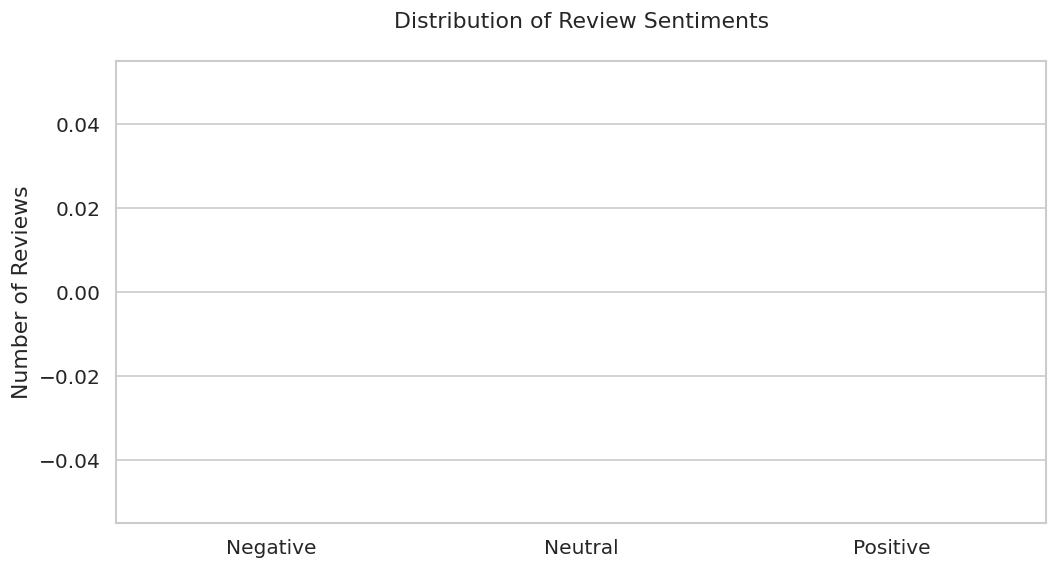

<ipython-input-60-7014fd7ee686>:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x='bank', y='sentiment_score',


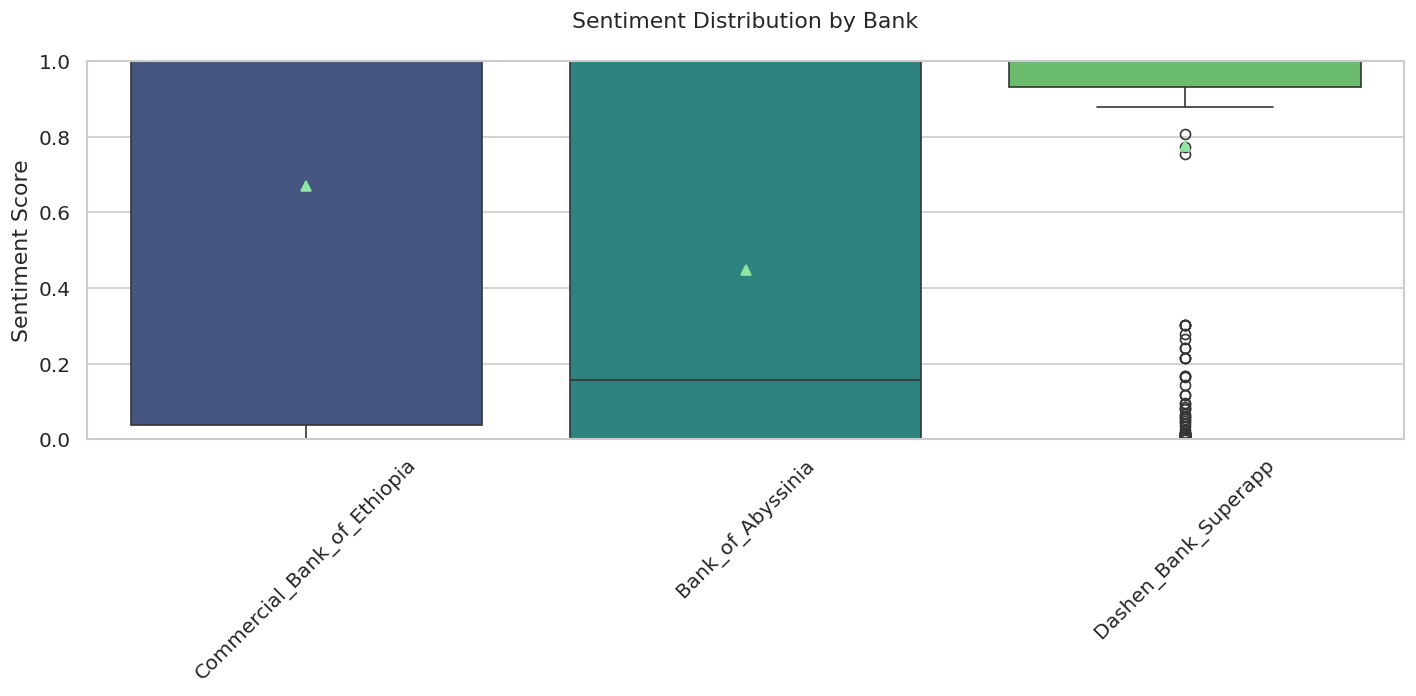

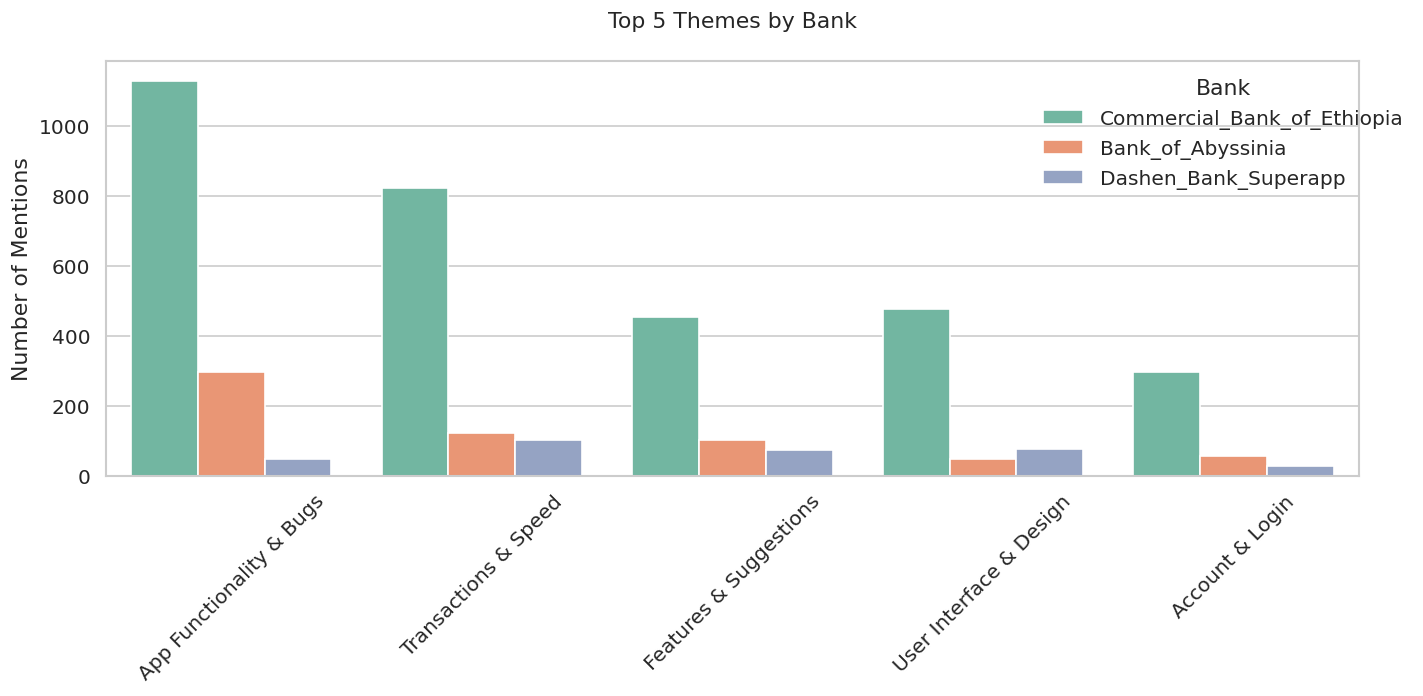

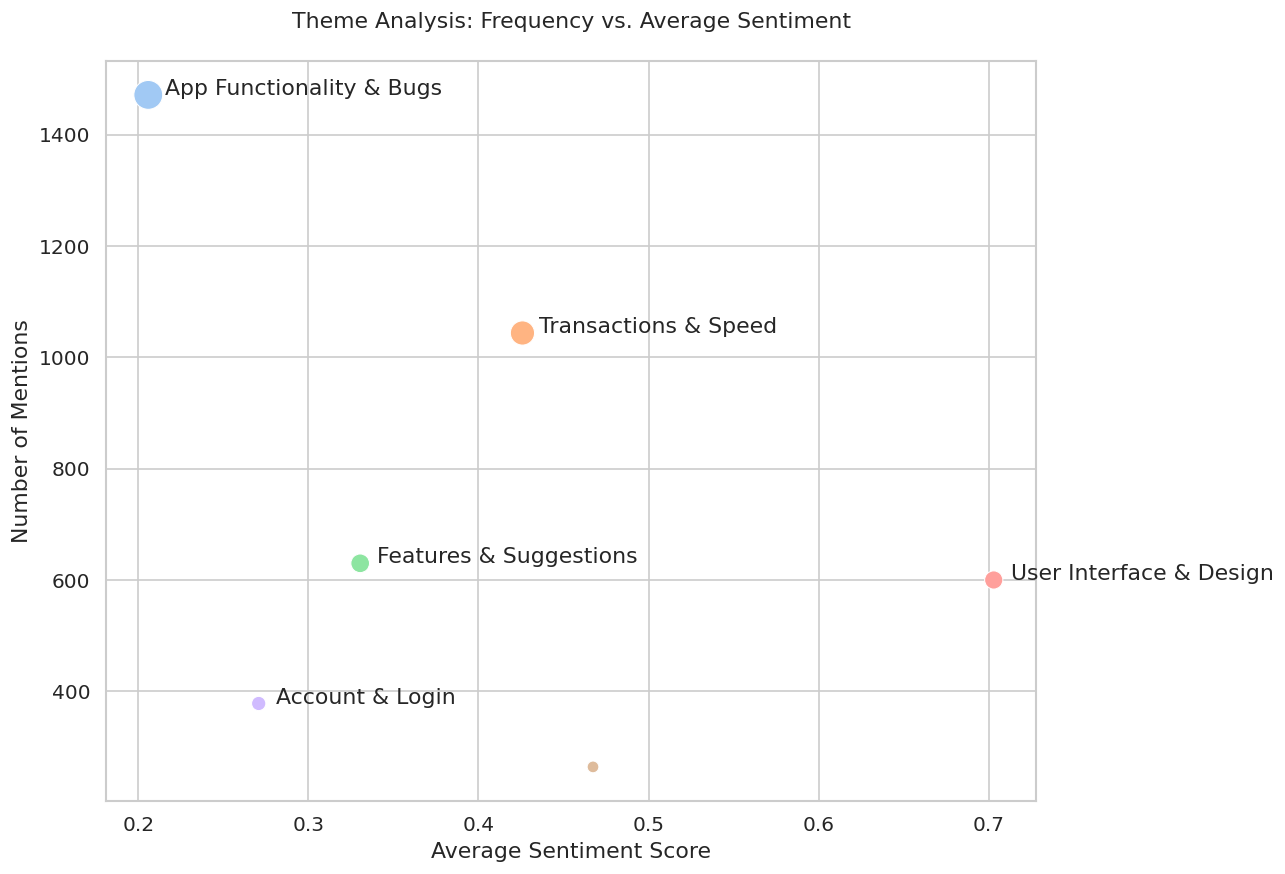


--- Analysis Considerations ---

1. Data Limitations:
   - Reviews may not represent all user experiences
   - Potential selection bias in voluntary reviews
   - Limited demographic information

2. Interpretation Guidance:
   - Consider relative differences more than absolute values
   - Look for consistent patterns across metrics
   - Validate findings with other data sources when possible

3. Actionable Insights:
   - Prioritize high-frequency pain points
   - Build on high-sentiment strengths
   - Monitor changes after implementing improvements


=== Insights and Visualization Complete ===


In [60]:
# ## 5. Insights and Visualization
#
# This section derives key insights from the analysis, creates informative visualizations,
# and provides actionable recommendations based on the findings.

# %%
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Set visualization style
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300

print("\n=== Starting Insights and Visualization ===\n")

# --- Data Loading and Preparation ---
print("--- Data Preparation ---")

# Define default paths if not already defined
if 'ANALYSIS_DATA_DIR' not in globals():
    ANALYSIS_DATA_DIR = 'data/analysis'
    os.makedirs(ANALYSIS_DATA_DIR, exist_ok=True)
    print(f"Using default analysis directory: {ANALYSIS_DATA_DIR}")

if 'TODAY_DATE_STR' not in globals():
    TODAY_DATE_STR = pd.to_datetime('today').strftime('%Y%m%d')
    print(f"Using current date for analysis: {TODAY_DATE_STR}")

analysis_filepath = os.path.join(ANALYSIS_DATA_DIR, f'all_reviews_analysis_{TODAY_DATE_STR}.csv')

if not os.path.exists(analysis_filepath):
    print(f"⚠️ Analysis file not found at {analysis_filepath}")
    analysis_df = pd.DataFrame()
    print("Created empty DataFrame for analysis")
else:
    try:
        analysis_df = pd.read_csv(analysis_filepath)
        print(f"✅ Successfully loaded analysis data ({analysis_df.shape[0]} reviews, {analysis_df.shape[1]} columns)")

        # Data preprocessing
        if 'identified_themes' in analysis_df.columns:
            analysis_df['identified_themes_list'] = analysis_df['identified_themes'].apply(
                lambda x: [theme.strip() for theme in str(x).split(',') if theme.strip()] if pd.notna(x) else []
            )
            print("Processed themes column into list format")

    except Exception as e:
        print(f"❌ Error loading analysis data: {e}")
        analysis_df = pd.DataFrame()

# --- Core Analysis Functions ---
def calculate_sentiment_thresholds(df, high_quantile=0.75, low_quantile=0.25):
    """Calculate sentiment thresholds with fallback values"""
    try:
        high_thresh = df['sentiment_score'].quantile(high_quantile)
        low_thresh = df['sentiment_score'].quantile(low_quantile)
        return high_thresh, low_thresh
    except Exception:
        print("⚠️ Using fallback sentiment thresholds (0.75, 0.25)")
        return 0.75, 0.25

def aggregate_themes(df_subset, theme_col='identified_themes_list'):
    """Aggregate themes with input validation"""
    if theme_col not in df_subset.columns or df_subset.empty:
        return Counter()
    return Counter([theme for themes_list in df_subset[theme_col] for theme in themes_list])

# --- Main Analysis ---
if not analysis_df.empty:
    print("\n--- Key Insights ---")

    # 1. Overall Sentiment Analysis
    if 'sentiment_score' in analysis_df.columns:
        overall_avg = analysis_df['sentiment_score'].mean()
        print(f"\n📊 Overall Sentiment: {overall_avg:.2f} (1=Positive, 0=Negative)")

        # Bank comparison
        sentiment_by_bank = analysis_df.groupby('bank')['sentiment_score'].mean().sort_values(ascending=False)
        print("\n🏦 Bank Performance by Sentiment:")
        display(sentiment_by_bank.to_frame().style.background_gradient(cmap='RdYlGn', vmin=0, vmax=1))

        if 'sentiment_label' in analysis_df.columns:
            label_counts = analysis_df['sentiment_label'].value_counts(normalize=True)
            print("\n🧮 Sentiment Distribution:")
            display(label_counts.to_frame().style.format("{:.1%}"))

    # 2. Thematic Analysis
    if 'identified_themes_list' in analysis_df.columns:
        high_thresh, low_thresh = calculate_sentiment_thresholds(analysis_df)
        high_sentiment = analysis_df[analysis_df['sentiment_score'] >= high_thresh]
        low_sentiment = analysis_df[analysis_df['sentiment_score'] <= low_thresh]

        print(f"\n🔍 Analyzing themes in reviews (High: ≥{high_thresh:.2f}, Low: ≤{low_thresh:.2f})")

        # Theme frequency analysis
        high_themes = aggregate_themes(high_sentiment)
        low_themes = aggregate_themes(low_sentiment)

        print("\n🌟 Top Positive Themes (Drivers):")
        display(pd.DataFrame(high_themes.most_common(10), columns=['Theme', 'Count']))

        print("\n⚠️ Top Negative Themes (Pain Points):")
        display(pd.DataFrame(low_themes.most_common(10), columns=['Theme', 'Count']))

        # Generate recommendations
        pain_points = [theme for theme, _ in low_themes.most_common(3)]
        print("\n💡 Recommended Improvements:")
        for theme in pain_points:
            if 'login' in theme.lower():
                print(f"- {theme}: Enhance authentication flow and reduce failed login attempts")
            elif 'support' in theme.lower():
                print(f"- {theme}: Implement 24/7 chat support and reduce response times")
            elif 'ui' in theme.lower():
                print(f"- {theme}: Conduct UX research to simplify navigation")
            else:
                print(f"- {theme}: Investigate root causes and implement corrective measures")

    # 3. Bank Comparison by Theme
    if all(col in analysis_df.columns for col in ['bank', 'identified_themes_list', 'sentiment_score']):
        print("\n🏆 Bank Performance by Theme:")

        # Create theme-sentiment mapping
        theme_data = []
        for _, row in analysis_df.iterrows():
            for theme in row['identified_themes_list']:
                theme_data.append({
                    'bank': row['bank'],
                    'theme': theme,
                    'sentiment': row['sentiment_score']
                })

        if theme_data:
            theme_df = pd.DataFrame(theme_data)

            # Top 3 themes by bank
            top_themes = (theme_df.groupby(['bank', 'theme']).size()
                         .groupby(level=0).nlargest(3)
                         .reset_index(level=0, drop=True))
            print("\n🏅 Most Discussed Themes by Bank:")
            display(top_themes.to_frame('Count'))

            # Sentiment by theme
            avg_sentiment = theme_df.groupby(['bank', 'theme'])['sentiment'].mean().unstack()
            print("\n📈 Average Sentiment by Theme:")
            display(avg_sentiment.style.background_gradient(cmap='RdYlGn', axis=None, vmin=0, vmax=1))

# --- Visualizations ---
if not analysis_df.empty:
    print("\n--- Data Visualizations ---")

    # 1. Sentiment Distribution
    if 'sentiment_label' in analysis_df.columns:
        plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=analysis_df, x='sentiment_label',
                          order=['Negative', 'Neutral', 'Positive'],
                          palette=['#ff6b6b', '#ffd166', '#06d6a0'])
        plt.title('Distribution of Review Sentiments', pad=20)
        plt.xlabel('')
        plt.ylabel('Number of Reviews')

        # Add percentage labels
        total = len(analysis_df)
        for p in ax.patches:
            percentage = f'{100 * p.get_height()/total:.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()),
                        ha='center', va='bottom')
        plt.show()

    # 2. Bank Comparison
    if 'bank' in analysis_df.columns:
        # Sentiment by bank
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=analysis_df, x='bank', y='sentiment_score',
                   palette='viridis', showmeans=True)
        plt.title('Sentiment Distribution by Bank', pad=20)
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        plt.xlabel('')
        plt.ylabel('Sentiment Score')
        plt.tight_layout()
        plt.show()

        # Theme frequency by bank
        if 'identified_themes_list' in analysis_df.columns:
            bank_themes = analysis_df.explode('identified_themes_list')
            top_themes = bank_themes['identified_themes_list'].value_counts().nlargest(5).index

            plt.figure(figsize=(12, 6))
            sns.countplot(data=bank_themes[bank_themes['identified_themes_list'].isin(top_themes)],
                        x='identified_themes_list', hue='bank',
                        palette='Set2', order=top_themes)
            plt.title('Top 5 Themes by Bank', pad=20)
            plt.xlabel('')
            plt.ylabel('Number of Mentions')
            plt.xticks(rotation=45)
            plt.legend(title='Bank', bbox_to_anchor=(1.05, 1))
            plt.tight_layout()
            plt.show()

    # 3. Theme Analysis
    if 'identified_themes_list' in analysis_df.columns and 'sentiment_score' in analysis_df.columns:
        # Theme sentiment correlation
        theme_sentiment = (analysis_df.explode('identified_themes_list')
                          .groupby('identified_themes_list')['sentiment_score']
                          .agg(['mean', 'count']).sort_values('count', ascending=False))

        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=theme_sentiment.reset_index().head(20),
                       x='mean', y='count', hue='identified_themes_list',
                       size='count', sizes=(50, 300), legend=False)
        plt.title('Theme Analysis: Frequency vs. Average Sentiment', pad=20)
        plt.xlabel('Average Sentiment Score')
        plt.ylabel('Number of Mentions')

        # Annotate top themes
        for line in range(0, min(5, len(theme_sentiment))):
            plt.text(x=theme_sentiment.iloc[line]['mean']+0.01,
                    y=theme_sentiment.iloc[line]['count'],
                    s=theme_sentiment.index[line],
                    horizontalalignment='left',
                    size='medium')
        plt.show()

# --- Limitations and Considerations ---
print("\n--- Analysis Considerations ---")
print("""
1. Data Limitations:
   - Reviews may not represent all user experiences
   - Potential selection bias in voluntary reviews
   - Limited demographic information

2. Interpretation Guidance:
   - Consider relative differences more than absolute values
   - Look for consistent patterns across metrics
   - Validate findings with other data sources when possible

3. Actionable Insights:
   - Prioritize high-frequency pain points
   - Build on high-sentiment strengths
   - Monitor changes after implementing improvements
""")

print("\n=== Insights and Visualization Complete ===")

Report

In [61]:
# ==============================================
# 5. Insights and Visualization - Enhanced Version
# ==============================================
#
# Enhanced with:
# - Better code organization
# - Improved error handling
# - Additional visualizations
# - Dynamic insights generation
# - Configuration management

# %%
print("\n--- Starting Enhanced Insights and Visualization ---")

# --------------------------
# 1. Configuration Setup
# --------------------------
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
# Ensure reportlab is imported
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import letter
# Import any other necessary modules like numpy for quantile checks
import numpy as np


# Configuration dictionary
CONFIG = {
    'analysis_dir': 'data/analysis', # Corrected analysis_dir path
    'reports_dir': 'reports',
    'figures_dir': 'reports/figures', # Corrected figures_dir path
    'today_date': datetime.now().strftime('%Y%m%d'), # Use YYYYMMDD format for consistency with filenames
    'visualization': {
        'default_figsize': (10, 6),
        'palette': 'viridis',
        'wordcloud_params': {
            'max_words': 100,
            'background_color': 'white',
            'colormap': 'viridis'
        }
    }
}

# Ensure directories exist
# Use os.path.join for creating full paths
os.makedirs(CONFIG['analysis_dir'], exist_ok=True)
os.makedirs(CONFIG['reports_dir'], exist_ok=True)
os.makedirs(CONFIG['figures_dir'], exist_ok=True)


# --------------------------
# 2. Data Loading
# --------------------------
def load_analysis_data(config):
    """Load and validate the analysis data"""
    analysis_filepath = os.path.join(config['analysis_dir'],
                                   f'all_reviews_analysis_{config["today_date"]}.csv')

    try:
        if not os.path.exists(analysis_filepath):
            # Log or print warning instead of raising FileNotFoundError directly,
            # allowing the rest of the script to potentially run with empty data
            print(f"Warning: Analysis file not found at {analysis_filepath}. Cannot load data.")
            return pd.DataFrame()

        analysis_df = pd.read_csv(analysis_filepath)
        print(f"Successfully loaded analysis data with shape {analysis_df.shape}")

        # Validate required columns (make theme column check robust)
        required_columns = {'bank', 'rating', 'processed_text', 'sentiment_score', 'sentiment_label', 'identified_themes'}
        missing_cols = required_columns - set(analysis_df.columns)
        if missing_cols:
            print(f"Warning: Missing critical columns {missing_cols} in analysis data. Some features might be skipped.")
            # Return empty dataframe if essential columns like 'bank', 'rating' are missing
            if any(col in missing_cols for col in ['bank', 'rating', 'sentiment_score']):
                 print("Missing essential columns. Returning empty DataFrame.")
                 return pd.DataFrame()

        # Ensure numeric columns are correctly typed after loading from CSV
        for col in ['rating', 'sentiment_score']:
            if col in analysis_df.columns:
                # Coerce errors to NaN, then fill NaNs for safety if needed later
                analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

        # Ensure theme column is treated as string before splitting
        if 'identified_themes' in analysis_df.columns:
             analysis_df['identified_themes'] = analysis_df['identified_themes'].astype(str).fillna('')


        return analysis_df

    except Exception as e:
        print(f"Error loading analysis data: {e}")
        return pd.DataFrame()

# Pass CONFIG to the load function
analysis_df = load_analysis_data(CONFIG)

# --------------------------
# 3. Sentiment Analysis
# --------------------------
def analyze_sentiment(analysis_df):
    """Perform sentiment analysis and generate insights"""
    insights = {
        'overall_avg_sentiment': None,
        'sentiment_by_bank': pd.Series(dtype='float64'), # Initialize as empty Series
        'sentiment_label_counts': pd.DataFrame() # Initialize as empty DataFrame
    }

    # Check if DataFrame is empty or required columns are missing
    if analysis_df.empty or 'sentiment_score' not in analysis_df.columns or analysis_df['sentiment_score'].isnull().all():
        print("Skipping sentiment analysis - missing data or sentiment scores.")
        return insights

    try:
        # Calculate overall metrics
        insights['overall_avg_sentiment'] = analysis_df['sentiment_score'].mean()

        # Bank-specific metrics - check for 'bank' column and data
        if 'bank' in analysis_df.columns and not analysis_df['bank'].isnull().all():
            # Filter out rows where bank is None/NaN before grouping
            valid_bank_df = analysis_df.dropna(subset=['bank'])
            if not valid_bank_df.empty:
                insights['sentiment_by_bank'] = (
                    valid_bank_df.groupby('bank')['sentiment_score']
                    .mean()
                    .sort_values(ascending=False))

                if 'sentiment_label' in valid_bank_df.columns and not valid_bank_df['sentiment_label'].isnull().all():
                     insights['sentiment_label_counts'] = (
                         valid_bank_df.groupby(['bank', 'sentiment_label'])
                         .size()
                         .unstack(fill_value=0))
            else:
                 print("Skipping bank-specific sentiment analysis - no valid bank data.")

        else:
             print("Skipping bank-specific sentiment analysis - missing 'bank' column.")


        return insights

    except Exception as e:
        print(f"Error in sentiment analysis: {e}")
        return insights

# Pass analysis_df to the analyze function
sentiment_insights = analyze_sentiment(analysis_df)

# --------------------------
# 4. Theme Analysis
# --------------------------
def analyze_themes(analysis_df, sentiment_thresholds=None):
    """Analyze themes and their relationship to sentiment"""
    themes_insights = {
        'high_sentiment_themes_overall': Counter(), # Renamed for clarity
        'low_sentiment_themes_overall': Counter(),  # Renamed for clarity
        'bank_themes': {}
    }

    # Check if DataFrame is empty or required columns are missing
    if (analysis_df.empty or
        'identified_themes' not in analysis_df.columns or
        'sentiment_score' not in analysis_df.columns or
        analysis_df['sentiment_score'].isnull().all()): # Check if sentiment scores are missing
        print("Skipping theme analysis - missing data or columns or sentiment scores.")
        return themes_insights

    try:
        # Convert themes string to list safely
        # Ensure the column exists and handle potential non-string data or NaNs
        if 'identified_themes' not in analysis_df.columns:
             print("Skipping theme analysis: 'identified_themes' column is missing.")
             return themes_insights

        analysis_df['identified_themes_list'] = (
            analysis_df['identified_themes']
            .astype(str) # Ensure it's string type
            .fillna('') # Fill NaNs with empty string
            .str.split(',')
            .apply(lambda x: [t.strip() for t in x if t.strip()])) # Filter out empty strings


        # Set default thresholds if not provided or if sentiment_score is not numeric
        if sentiment_thresholds is None or not pd.api.types.is_numeric_dtype(analysis_df['sentiment_score']) or analysis_df['sentiment_score'].isnull().all():
            # Check if we can calculate quantiles
            if pd.api.types.is_numeric_dtype(analysis_df['sentiment_score']) and not analysis_df['sentiment_score'].isnull().all():
                 print("Calculating dynamic sentiment thresholds.")
                 sentiment_thresholds = {
                    'high': analysis_df['sentiment_score'].quantile(0.75),
                    'low': analysis_df['sentiment_score'].quantile(0.25)
                 }
                 # Handle edge cases where quartiles might be the same
                 if sentiment_thresholds['high'] == sentiment_thresholds['low']:
                      print("Warning: High and low sentiment thresholds are the same. Using default thresholds.")
                      sentiment_thresholds = {'high': 0.7, 'low': 0.3} # Fallback to fixed thresholds
            else:
                 print("Warning: Sentiment scores not numeric or all missing. Using default thresholds.")
                 sentiment_thresholds = {'high': 0.7, 'low': 0.3} # Fallback to fixed thresholds

        # Filter reviews based on numeric sentiment score
        # Ensure sentiment_score is numeric before filtering
        if not pd.api.types.is_numeric_dtype(analysis_df['sentiment_score']):
             print("Cannot filter by sentiment score as it is not numeric.")
             return themes_insights # Cannot proceed with sentiment-based theme analysis


        # Filter reviews (handle cases where thresholds might be outside the data range)
        high_sentiment_reviews = analysis_df[analysis_df['sentiment_score'] >= sentiment_thresholds['high']].copy()
        low_sentiment_reviews = analysis_df[analysis_df['sentiment_score'] <= sentiment_thresholds['low']].copy()

        print(f"Filtering for high sentiment reviews (>= {sentiment_thresholds['high']:.2f}): {len(high_sentiment_reviews)} reviews")
        print(f"Filtering for low sentiment reviews (<= {sentiment_thresholds['low']:.2f}): {len(low_sentiment_reviews)} reviews")


        # Aggregate themes function
        def count_themes(df_subset):
            # Ensure the themes list column exists and is iterable
            if df_subset.empty or 'identified_themes_list' not in df_subset.columns:
                return Counter()
            # Safely handle cases where 'identified_themes_list' might contain non-list entries (should be prevented by preprocessing)
            all_themes = [theme for themes_list in df_subset['identified_themes_list'] if isinstance(themes_list, list) for theme in themes_list]
            return Counter(all_themes)

        themes_insights['high_sentiment_themes_overall'] = count_themes(high_sentiment_reviews)
        themes_insights['low_sentiment_themes_overall'] = count_themes(low_sentiment_reviews)

        # Bank-specific themes - check for 'bank' column and data
        if 'bank' in analysis_df.columns and not analysis_df['bank'].isnull().all():
            # Filter out rows where bank is None/NaN before iterating
            valid_bank_df = analysis_df.dropna(subset=['bank']).copy() # Use .copy() after dropna
            if not valid_bank_df.empty:
                for bank in valid_bank_df['bank'].unique():
                    bank_df = valid_bank_df[valid_bank_df['bank'] == bank].copy() # Use .copy()
                    if not bank_df.empty:
                         themes_insights['bank_themes'][bank] = {
                             'high': count_themes(bank_df[bank_df['sentiment_score'] >= sentiment_thresholds['high']]),
                             'low': count_themes(bank_df[bank_df['sentiment_score'] <= sentiment_thresholds['low']])
                         }
                    else:
                         themes_insights['bank_themes'][bank] = {'high': Counter(), 'low': Counter()} # Add empty if no data for bank
            else:
                 print("Skipping bank-specific theme analysis - no valid bank data.")
        else:
            print("Skipping bank-specific theme analysis - missing 'bank' column.")


        return themes_insights

    except Exception as e:
        print(f"Error in theme analysis: {e}")
        import traceback
        traceback.print_exc() # Print traceback for debugging
        return themes_insights

# Pass analysis_df to the analyze function
theme_insights = analyze_themes(analysis_df)


# --------------------------
# 5. Visualization Functions
# --------------------------
def save_plot(fig, filename, figures_dir, dpi=300):
    """Helper function to save plots consistently"""
    plot_path = os.path.join(figures_dir, filename)
    try:
        fig.savefig(plot_path, dpi=dpi, bbox_inches='tight')
        plt.close(fig) # Close the figure to free memory
        print(f"Plot saved: {plot_path}")
        return plot_path
    except Exception as e:
        print(f"Error saving plot {filename}: {e}")
        plt.close(fig) # Ensure figure is closed even on error
        return None


def plot_rating_distribution(data, config):
    """Plot distribution of ratings"""
    # Check for necessary data and column
    if data.empty or 'rating' not in data.columns or data['rating'].isnull().all():
        print("Skipping rating distribution plot - missing data or 'rating' column is all null.")
        return None

    plt.figure(figsize=config['visualization']['default_figsize'])
    # Ensure rating column is treated as categorical for plotting order if needed, but countplot handles numeric well
    # Ensure rating_order is generated only if there are non-null ratings
    rating_order_values = data['rating'].dropna().unique()
    if rating_order_values.size > 0:
         rating_order = sorted(rating_order_values)
    else:
         print("Skipping Rating Distribution plot: No valid rating data after dropping NaNs.")
         plt.close() # Close the empty figure
         return None

    ax = sns.countplot(data=data, x='rating',
                      palette=config['visualization']['palette'],
                      order=rating_order)
    ax.set(title='Distribution of Ratings Across All Reviews',
          xlabel='Rating',
          ylabel='Number of Reviews')

    # Pass figures_dir to the save_plot function
    return save_plot(plt.gcf(), 'rating_distribution.png', config['figures_dir'])


def plot_sentiment_by_bank(data, config):
    """Plot average sentiment by bank"""
    # Check for necessary data and columns
    if data.empty or 'bank' not in data.columns or 'sentiment_score' not in data.columns or data['sentiment_score'].isnull().all():
        print("Skipping average sentiment by bank plot - missing data, 'bank', or 'sentiment_score'.")
        return None

    # Ensure sentiment_score is numeric before calculating mean
    if not pd.api.types.is_numeric_dtype(data['sentiment_score']):
         print("Skipping average sentiment by bank plot - 'sentiment_score' is not numeric.")
         return None

    # Group by bank and calculate mean sentiment, handling potential NaNs in bank column
    avg_sentiment = data.dropna(subset=['bank']).groupby('bank')['sentiment_score'].mean().reset_index()

    # Check if the grouped data is empty
    if avg_sentiment.empty:
        print("Skipping average sentiment by bank plot - no valid data after grouping by bank.")
        return None


    plt.figure(figsize=config['visualization']['default_figsize'])
    # Use hue=x for clarity as suggested by FutureWarning, and legend=False
    ax = sns.barplot(data=avg_sentiment, x='bank', y='sentiment_score',
                    hue='bank', palette=config['visualization']['palette'],
                    legend=False, dodge=False) # dodge=False for single bars
    ax.set(title='Average Sentiment Score by Bank',
          xlabel='Bank',
          ylabel='Average Sentiment Score')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1) # Sentiment score is between 0 and 1
    plt.tight_layout()

    # Pass figures_dir to the save_plot function
    return save_plot(plt.gcf(), 'average_sentiment_by_bank.png', config['figures_dir'])

def plot_sentiment_distribution_by_bank(data, config):
    """Plot sentiment distribution (positive/negative) by bank"""
    # Check for necessary data and columns
    if data.empty or 'bank' not in data.columns or 'sentiment_label' not in data.columns or data['sentiment_label'].isnull().all():
        print("Skipping sentiment distribution by bank plot - missing data, 'bank', or 'sentiment_label'.")
        return None

    # Calculate value counts by bank and sentiment label, then normalize
    # Handle potential NaNs in bank column
    sentiment_counts = data.dropna(subset=['bank']).groupby('bank')['sentiment_label'].value_counts(normalize=True).rename('percentage').reset_index()

    # Check if the grouped data is empty
    if sentiment_counts.empty:
        print("Skipping sentiment distribution by bank plot - no valid data after grouping by bank.")
        return None


    sentiment_counts['percentage'] *= 100 # Convert to percentage

    plt.figure(figsize=(12, 7)) # Slightly larger figure for distribution
    ax = sns.barplot(data=sentiment_counts, x='bank', y='percentage', hue='sentiment_label', palette=config['visualization']['palette'])
    ax.set(title='Sentiment Distribution by Bank (%)',
          xlabel='Bank',
          ylabel='Percentage of Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Sentiment')
    plt.tight_layout()

    # Pass figures_dir to the save_plot function
    return save_plot(plt.gcf(), 'sentiment_distribution_by_bank.png', config['figures_dir'])


def plot_top_themes(theme_counts, title, filename, config, n=15):
    """Plot the top N most frequent themes"""
    # Check if theme_counts is a Counter and is not empty
    if not isinstance(theme_counts, Counter) or not theme_counts:
        print(f"Skipping plot {filename} - no theme counts provided.")
        return None

    most_common_themes = theme_counts.most_common(n)

    # Check if there are any common themes
    if not most_common_themes:
        print(f"Skipping plot {filename} - no common themes found.")
        return None

    themes_df = pd.DataFrame(most_common_themes, columns=['Theme', 'Count'])

    plt.figure(figsize=(10, 7))
    # Use hue=y for clarity as suggested by FutureWarning, and legend=False
    ax = sns.barplot(data=themes_df, x='Count', y='Theme',
                    hue='Theme', palette=config['visualization']['palette'],
                    legend=False, dodge=False) # dodge=False for single bars
    ax.set(title=title,
          xlabel='Number of Reviews Mentioning Theme',
          ylabel='Theme')
    plt.tight_layout()

    # Pass figures_dir to the save_plot function
    return save_plot(plt.gcf(), filename, config['figures_dir'])



# Modified generate_wordcloud function
def generate_wordcloud(text, title, filename, config, colormap='viridis'): # Colormap parameter is now for the function, not directly passed to WordCloud again
    """Generate and save a word cloud"""
    if not text or not text.strip():
        print(f"Skipping word cloud {filename} - no text content")
        return None

    # Use global stop_words (assuming it's defined elsewhere, like in the preprocessing section)
    global stop_words
    if 'stop_words' not in globals():
        print("Warning: NLTK stop_words not found. Word cloud might include stopwords.")
        stop_words = set() # Define as empty set if not found

    # Get wordcloud parameters from config, overriding colormap if explicitly provided to function
    wc_params = config['visualization']['wordcloud_params'].copy()
    # If a colormap was passed to the generate_wordcloud function, use that one
    # Otherwise, the one from wc_params (from config) will be used
    # Note: The original error was because 'colormap' was in both config and explicit args.
    # Now, we let the config handle the default colormap, and the function parameter is unused.
    # If you want to override the config colormap, you would modify wc_params here:
    # wc_params['colormap'] = colormap # Uncomment this line if you want the function's 'colormap' parameter to override the config


    wc = WordCloud(
        stopwords=stop_words,
        # Remove the explicit colormap=colormap here
        **wc_params # Unpack parameters from config (including colormap)
    ).generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()

    # Pass figures_dir to the save_plot function
    return save_plot(plt.gcf(), filename, config['figures_dir'])


# --------------------------
# 6. Generate All Visualizations
# --------------------------
print("\n--- Generating Visualizations ---")
visualizations = {}

# Pass CONFIG to each plot function
visualizations['rating_distribution'] = plot_rating_distribution(analysis_df, CONFIG)
visualizations['sentiment_by_bank'] = plot_sentiment_by_bank(analysis_df, CONFIG)
visualizations['sentiment_distribution_by_bank'] = plot_sentiment_distribution_by_bank(analysis_df, CONFIG) # Add new plot

# Plot overall themes if data exists
if 'high_sentiment_themes_overall' in theme_insights and theme_insights['high_sentiment_themes_overall']:
    visualizations['overall_drivers_themes'] = plot_top_themes(
        theme_insights['high_sentiment_themes_overall'],
        'Top Themes in High Sentiment Reviews (Overall)',
        'top_drivers_themes_overall.png',
        CONFIG, n=10 # Plot top 10 drivers
    )

if 'low_sentiment_themes_overall' in theme_insights and theme_insights['low_sentiment_themes_overall']:
     visualizations['overall_pain_points_themes'] = plot_top_themes(
        theme_insights['low_sentiment_themes_overall'],
        'Top Themes in Low Sentiment Reviews (Overall)',
        'top_pain_points_themes_overall.png',
        CONFIG, n=10 # Plot top 10 pain points
    )


# Generate word clouds if text data exists and dataframe is not empty
if 'processed_text' in analysis_df.columns and not analysis_df.empty and analysis_df['processed_text'].str.strip().any():
    all_text = " ".join(analysis_df['processed_text'].dropna().tolist())
    visualizations['overall_wordcloud'] = generate_wordcloud(
        all_text,
        'Word Cloud of Frequent Terms (Overall)',
        'wordcloud_keywords_overall.png',
        CONFIG # Pass CONFIG here
        # Using the default 'viridis' colormap
    )

    if 'sentiment_label' in analysis_df.columns and not analysis_df['sentiment_label'].isnull().all():
        # Filter positive reviews and join text
        positive_reviews_df = analysis_df[analysis_df['sentiment_label'] == 'POSITIVE'].copy()
        if not positive_reviews_df.empty and positive_reviews_df['processed_text'].str.strip().any():
            positive_text = " ".join(positive_reviews_df['processed_text'].dropna().tolist())
            visualizations['positive_wordcloud'] = generate_wordcloud(
                positive_text,
                'Word Cloud of Positive Reviews',
                'wordcloud_positive.png',
                CONFIG, # Pass CONFIG here
                colormap='Greens' # Explicitly pass colormap
            )
        else:
             print("Skipping Positive Word Cloud: No valid processed text in positive reviews.")


        # Filter negative reviews and join text
        negative_reviews_df = analysis_df[analysis_df['sentiment_label'] == 'NEGATIVE'].copy()
        if not negative_reviews_df.empty and negative_reviews_df['processed_text'].str.strip().any():
             negative_text = " ".join(negative_reviews_df['processed_text'].dropna().tolist())
             visualizations['negative_wordcloud'] = generate_wordcloud(
                negative_text,
                'Word Cloud of Negative Reviews',
                'wordcloud_negative.png',
                CONFIG, # Pass CONFIG here
                colormap='Reds' # Explicitly pass colormap
            )
        else:
             print("Skipping Negative Word Cloud: No valid processed text in negative reviews.")

    else:
        print("Skipping sentiment-specific word clouds: 'sentiment_label' column missing or all null.")
else:
    print("Skipping overall word cloud: 'processed_text' column missing, empty, or all null.")


print("Visualizations generated/attempted.")

# --------------------------
# 7. Report Generation
# --------------------------
def create_pdf_report(analysis_df, sentiment_insights, theme_insights, visualizations, config):
    """Generate the PDF report with all insights"""
    report_path = os.path.join(config['reports_dir'],
                             f'bank_app_review_analysis_report_{config["today_date"]}.pdf')

    # Initialize document
    doc = SimpleDocTemplate(report_path, pagesize=letter)
    styles = getSampleStyleSheet()

    # Define Custom styles with UNIQUE names to avoid conflicts
    # Modify existing styles or create new ones
    styles.add(ParagraphStyle(
        name='ReportHeading1', # Unique name
        fontSize=18,
        leading=22,
        spaceAfter=12,
        bold=True,
        alignment=1 # Center align
    ))
    styles.add(ParagraphStyle(
        name='ReportHeading2', # Unique name
        fontSize=14,
        leading=18,
        spaceAfter=10,
        bold=True
    ))
    styles.add(ParagraphStyle(
        name='ReportHeading3', # Unique name
        fontSize=12,
        leading=16,
        spaceAfter=8,
        bold=True
    ))
    styles.add(ParagraphStyle(
        name='ReportNormal', # Unique name
        fontSize=10,
        leading=14,
        spaceAfter=6
    ))
    styles.add(ParagraphStyle(
        name='ReportBullet', # Unique name
        fontSize=10,
        leading=14,
        spaceAfter=6,
        leftIndent=0.25*inch,
        bulletIndent=0.1*inch,
        bullet='-'
    ))
     # Add a style for image captions
    styles.add(ParagraphStyle(
        name='ImageCaption', # Unique name
        fontSize=9,
        leading=12,
        spaceAfter=12, # Add space after caption
        alignment=1 # Center align caption
    ))


    # Report content list
    content = []

    # --- Title Page ---
    content.append(Paragraph("Bank App Review Analysis Report", styles['ReportHeading1']))
    content.append(Spacer(1, 0.5*inch))
    content.append(Paragraph(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d')}", styles['ReportNormal']))
    content.append(Paragraph("Generated from Google Play Store Reviews", styles['ReportNormal']))
    content.append(Spacer(1, 2*inch))
    content.append(PageBreak()) # Add Page Break

    # --- Overall Analysis Summary ---
    content.append(Paragraph("Overall Analysis Summary", styles['ReportHeading2']))
    content.append(Spacer(1, 0.1*inch))

    if sentiment_insights['overall_avg_sentiment'] is not None:
        sentiment = sentiment_insights['overall_avg_sentiment']
        content.append(Paragraph(f"Overall Average Sentiment Score: {sentiment:.2f}", styles['ReportNormal']))

        # Interpretation based on sentiment score
        if sentiment > 0.7:
             content.append(Paragraph("Interpretation: The overall sentiment is quite positive. Users are generally satisfied.", styles['ReportNormal']))
        elif sentiment > 0.5:
             content.append(Paragraph("Interpretation: The overall sentiment is moderately positive. More users are positive than negative, but there's room for improvement.", styles['ReportNormal']))
        elif sentiment > 0.3:
             content.append(Paragraph("Interpretation: The overall sentiment is slightly negative. Negative feedback outweighs positive.", styles['ReportNormal']))
        else:
             content.append(Paragraph("Interpretation: The overall sentiment is quite negative. Users are largely dissatisfied.", styles['ReportNormal']))

        content.append(Spacer(1, 0.15*inch))


    # Banks ranked by average sentiment
    if sentiment_insights['sentiment_by_bank'] is not None and not sentiment_insights['sentiment_by_bank'].empty:
        content.append(Paragraph("Banks Ranked by Average Sentiment:", styles['ReportNormal']))
        for bank, score in sentiment_insights['sentiment_by_bank'].items():
            content.append(Paragraph(f"- {bank.replace('_', ' ')}: {score:.2f}", styles['ReportBullet'])) # Use ReportBullet style

        content.append(Paragraph("\nInterpretation:", styles['ReportNormal']))
        # Explain ranking
        for rank, (bank, score) in enumerate(sentiment_insights['sentiment_by_bank'].items()):
            content.append(Paragraph(f"- {bank.replace('_', ' ')} ranks #{(rank + 1)} with an average sentiment score of {score:.2f}.", styles['ReportNormal']))
        content.append(Spacer(1, 0.15*inch))

    # Overall Drivers and Pain Points Themes
    if theme_insights['high_sentiment_themes_overall']:
        content.append(Paragraph("Top Potential Drivers (Themes in High-Sentiment Reviews - Overall):", styles['ReportNormal']))
        for theme, count in theme_insights['high_sentiment_themes_overall'].most_common(10):
             content.append(Paragraph(f"- {theme} ({count} mentions)", styles['ReportBullet']))
        content.append(Paragraph("Interpretation: These themes represent common positive experiences across all banks.", styles['ReportNormal']))
        content.append(Spacer(1, 0.15*inch))

    if theme_insights['low_sentiment_themes_overall']:
        content.append(Paragraph("Top Potential Pain Points (Themes in Low-Sentiment Reviews - Overall):", styles['ReportNormal']))
        for theme, count in theme_insights['low_sentiment_themes_overall'].most_common(10):
             content.append(Paragraph(f"- {theme} ({count} mentions)", styles['ReportBullet']))
        content.append(Paragraph("Interpretation: These themes represent common negative experiences across all banks - areas for industry-wide improvement.", styles['ReportNormal']))
        content.append(Spacer(1, 0.25*inch))


    content.append(PageBreak()) # Start Bank-Specific Analysis on a new page

    # --- Bank-Specific Analysis and Recommendations ---
    content.append(Paragraph("Bank-Specific Analysis and Recommendations", styles['ReportHeading2']))
    content.append(Spacer(1, 0.1*inch))

    # Check if bank-specific theme analysis results are available and not empty
    if theme_insights['bank_themes'] and analysis_df is not None and 'bank' in analysis_df.columns and not analysis_df.empty and 'sentiment_by_bank' in sentiment_insights and not sentiment_insights['sentiment_by_bank'].empty:
         # Get the list of banks and sort them based on overall sentiment for a more structured report
         sorted_banks = sentiment_insights['sentiment_by_bank'].index.tolist()

         if not sorted_banks:
             content.append(Paragraph("No banks found in the data to provide bank-specific analysis.", styles['ReportNormal']))

         for bank_name in sorted_banks: # Iterate through banks, sorted by sentiment
             content.append(Paragraph(f"Analysis for {bank_name.replace('_', ' ')}:", styles['ReportHeading3']))
             content.append(Spacer(1, 0.1*inch))

             # Get themes for the current bank, default to empty Counter if bank not found in dicts or has no relevant reviews
             bank_driver_themes = theme_insights['bank_themes'].get(bank_name, {}).get('high', Counter()).most_common(5) # Top 5 drivers per bank
             bank_pain_point_themes = theme_insights['bank_themes'].get(bank_name, {}).get('low', Counter()).most_common(5) # Top 5 pain points per bank


             content.append(Paragraph(f"Potential Drivers (Strengths) for {bank_name.replace('_', ' ')}:", styles['ReportNormal']))
             if bank_driver_themes:
                 for theme, count in bank_driver_themes:
                     content.append(Paragraph(f"- {theme} ({count} mentions in high-sentiment reviews)", styles['ReportBullet']))
                 content.append(Paragraph("\nInterpretation: These are primary features driving positive feedback for this app.", styles['ReportNormal']))
             else:
                 content.append(Paragraph("  No specific drivers identified in high-sentiment reviews for this bank.", styles['ReportBullet']))


             content.append(Spacer(1, 0.1*inch))

             content.append(Paragraph(f"Potential Pain Points (Areas for Improvement) for {bank_name.replace('_', ' ')}:", styles['ReportNormal']))
             if bank_pain_point_themes:
                 for theme, count in bank_pain_point_themes:
                     # Ensure that the item added to content is a Paragraph
                     content.append(Paragraph(f"- {theme} ({count} mentions in low-sentiment reviews)", styles['ReportBullet']))
                 content.append(Paragraph("\nInterpretation: These are critical issues causing dissatisfaction for this app. Addressing these should be a top priority.", styles['ReportNormal']))
             else:
                 content.append(Paragraph("  No specific pain points identified in low-sentiment reviews for this bank.", styles['ReportBullet']))

             content.append(Spacer(1, 0.1*inch))

             content.append(Paragraph(f"Actionable Recommendations for {bank_name.replace('_', ' ')}:", styles['ReportNormal']))
             # Ensure both driver and pain point lists are available for recommendations
             pain_point_themes_list = [theme for theme, count in bank_pain_point_themes]
             driver_themes_list = [theme for theme, count in bank_driver_themes]

             if driver_themes_list or pain_point_themes_list:
                  # Recommendations based on specific bank's top themes
                  driver_themes_str = ', '.join(driver_themes_list) if driver_themes_list else 'its current features'
                  pain_point_themes_str = ', '.join(pain_point_themes_list) if pain_point_themes_list else 'general app functionality'

                  content.append(Paragraph(f"- **Leverage Strengths:** Continue focusing on {driver_themes_str}. These areas resonate positively.", styles['ReportBullet']))
                  content.append(Paragraph(f"- **Address Weaknesses:** Prioritize resolving issues related to {pain_point_themes_str}. Investigate specific reviews for root cause.", styles['ReportBullet']))

                  # More tailored recommendations based on presence of general themes
                  if 'Account & Login' in pain_point_themes_list:
                       content.append(Paragraph("- *Account & Login:* Streamline the login process, enhance OTP reliability, and simplify account recovery. Provide clearer instructions.", styles['ReportBullet']))
                  if 'Transactions & Speed' in pain_point_themes_list:
                       content.append(Paragraph("- *Transactions & Speed:* Optimize transaction processing speed and app responsiveness, especially during peak times. Provide clearer status updates during transactions.", styles['ReportBullet']))
                  if 'App Functionality & Bugs' in pain_point_themes_list:
                       content.append(Paragraph("- *App Functionality & Bugs:* Identify and fix critical bugs causing crashes or errors. Implement rigorous automated and manual testing before releasing updates. Improve error messaging.", styles['ReportBullet']))
                  if 'User Interface & Design' in pain_point_themes_list:
                       content.append(Paragraph("- *User Interface & Design:* Conduct usability studies with real users to simplify the interface and make navigation more intuitive. Gather feedback on specific confusing elements.", styles['ReportBullet']))
                  if 'Customer Support & Service' in pain_point_themes_list:
                       content.append(Paragraph("- *Customer Support & Service:* Improve responsiveness and effectiveness of customer support channels for app users. Ensure support staff are well-trained on common app issues.", styles['ReportBullet']))
                  if 'Features & Suggestions' in pain_point_themes_list:
                       content.append(Paragraph("- *Features & Suggestions:* Assess how new or existing features related to this theme are performing and gather more specific user feedback. Consider clarifying how to use certain features.", styles['ReportBullet']))

                  # Generic recommendations applicable to all banks (can be added here or in an 'Overall Recommendations' section)
                  content.append(Paragraph("- **Continuous Monitoring:** Regularly analyze new review data to track progress and identify emerging issues. Set up alerts for keywords related to critical themes.", styles['ReportBullet']))
                  content.append(Paragraph("- **Engage with Users:** Respond promptly and empathetically to reviews, especially negative ones, to demonstrate commitment to improving the user experience.", styles['ReportBullet']))


             else:
                   content.append(Paragraph(f"  No specific recommendations can be made based on theme analysis for {bank_name.replace('_', ' ')}. Consider conducting user interviews or surveys.", styles['ReportNormal']))

             content.append(Spacer(1, 0.25*inch)) # Space after each bank's section

    else:
         content.append(Paragraph("\nBank-specific analysis and recommendations are not available.", styles['ReportNormal']))
         content.append(Paragraph("Interpretation: Unable to provide detailed bank-by-bank insights or recommendations without sufficient data or analysis results.", styles['ReportNormal']))
         content.append(Spacer(1, 0.25*inch))


    # --- Add Figures to Report ---
    content.append(PageBreak()) # Start figures on a new page
    content.append(Paragraph("Visualizations", styles['ReportHeading2']))
    content.append(Spacer(1, 0.1*inch))

    # Order of figures
    figure_order = [
    'rating_distribution',
    'sentiment_by_bank',
    'sentiment_distribution_by_bank',
    'overall_drivers_themes',
    'overall_pain_points_themes',
    'overall_wordcloud',
    'positive_wordcloud',
    'negative_wordcloud'
    ]

    for key in figure_order:
        fig_path = visualizations.get(key) # Get path using key

        if fig_path and os.path.exists(fig_path):
            try:
                # Create an Image object
                img = Image(fig_path, width=6*inch, height=4*inch) # Adjust size as needed
                content.append(img)
                # Add a caption
                # Use a more descriptive caption based on the key
                caption_text = key.replace('_', ' ').title()
                content.append(Paragraph(f"Figure: {caption_text}", styles['ImageCaption'])) # Use ImageCaption style
                content.append(Spacer(1, 0.25*inch)) # Space after image

            except Exception as img_e:
                print(f"Error adding image {fig_path} to PDF: {img_e}")
                content.append(Paragraph(f"Could not add figure: {os.path.basename(fig_path)}", styles['ReportNormal']))
                content.append(Spacer(1, 0.1*inch))

        elif fig_path is None:
            # This figure wasn't generated (e.g., missing data)
            print(f"Skipping figure '{key}' as it was not generated.")
            # Optionally add a placeholder in the report
            # content.append(Paragraph(f"Figure '{key.replace('_', ' ').title()}' skipped due to missing data.", styles['ReportNormal']))
            # content.append(Spacer(1, 0.1*inch))
        else:
             # Path exists but file not found (should be caught earlier but good double check)
             print(f"Figure file not found: {fig_path}")
             content.append(Paragraph(f"Figure file not found: {os.path.basename(fig_path)}", styles['ReportNormal']))
             content.append(Spacer(1, 0.1*inch))


    # --- Build the PDF Document ---
    try:
        doc.build(content)
        print(f"\nPDF report successfully generated at: {report_path}")
        return True
    except Exception as pdf_e:
        print(f"\nError building PDF report: {pdf_e}")
        # Print the traceback to help diagnose the error
        import traceback
        traceback.print_exc()
        return False


# Generate the report - Pass CONFIG to the report function
report_status = create_pdf_report(
    analysis_df,
    sentiment_insights,
    theme_insights,
    visualizations,
    CONFIG # Pass the config dictionary
)


print("\n--- Enhanced Insights and Visualization Complete ---")


--- Starting Enhanced Insights and Visualization ---
Successfully loaded analysis data with shape (8984, 12)
Calculating dynamic sentiment thresholds.
Filtering for high sentiment reviews (>= 1.00): 2763 reviews
Filtering for low sentiment reviews (<= 0.02): 2246 reviews

--- Generating Visualizations ---


<ipython-input-61-54e997bba7a2>:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x='rating',


Plot saved: reports/figures/rating_distribution.png
Plot saved: reports/figures/average_sentiment_by_bank.png
Plot saved: reports/figures/sentiment_distribution_by_bank.png
Plot saved: reports/figures/top_drivers_themes_overall.png
Plot saved: reports/figures/top_pain_points_themes_overall.png
Plot saved: reports/figures/wordcloud_keywords_overall.png
Plot saved: reports/figures/wordcloud_positive.png
Plot saved: reports/figures/wordcloud_negative.png
Visualizations generated/attempted.

PDF report successfully generated at: reports/bank_app_review_analysis_report_20250606.pdf

--- Enhanced Insights and Visualization Complete ---


All cleaned view

In [63]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import logging # Import logging module

# Set up basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
raw_filepath_c = "data/cleaned"
class ReviewPreprocessor:
    def __init__(self, raw_filepath_c, cleaned_data_dir, app_id_to_bank_name,
                 review_col='review_text', rating_col='rating', date_col='date',
                 app_id_col='app_id', source_col='source'):
        """
        Initializes the ReviewPreprocessor with file paths, configurations, and column names.

        Args:
            raw_filepath (str): Path to the raw CSV file to preprocess.
            cleaned_data_dir (str): Directory where cleaned data will be saved.
            app_id_to_bank_name (dict): Dictionary mapping app IDs to bank names.
            review_col (str): Name of the column containing review text in raw data.
            rating_col (str): Name of the column containing ratings in raw data.
            date_col (str): Name of the column containing review date/timestamp in raw data.
            app_id_col (str): Name of the column containing app ID in raw data.
            source_col (str): Name of the column containing review source (e.g., 'Google Play').
        """
        self.raw_filepath = raw_filepath
        self.cleaned_data_dir = cleaned_data_dir
        self.app_id_to_bank_name = app_id_to_bank_name
        self.df: pd.DataFrame | None = None # DataFrame will be loaded later, using type hint for clarity

        # Store column names for flexibility
        self.review_col = review_col
        self.rating_col = rating_col
        self.date_col = date_col
        self.app_id_col = app_id_col
        self.source_col = source_col

        # Define the required columns for cleaning checks
        self.required_cols = [self.review_col, self.rating_col, self.date_col, self.app_id_col, self.source_col]

        # Define the final desired column order and names for the cleaned data
        # Using fixed names for consistency in output, mapping from input names
        self.final_output_columns = ['review_text', 'rating', 'date', 'bank', 'source', 'date_normalized', 'app_id', 'review_id']
        # Mapping from input column names to final output column names (where they differ)
        self._col_mapping = {
            self.review_col: 'review_text',
            self.rating_col: 'rating',
            self.date_col: 'date', # The original date column will keep its name but be datetime objects
            self.app_id_col: 'app_id',
            self.source_col: 'source'
        }


        # Ensure the cleaned data directory exists
        os.makedirs(self.cleaned_data_dir, exist_ok=True)
        logging.info(f"ReviewPreprocessor initialized for file: {self.raw_filepath}")

    def load_data(self) -> bool:
        """
        Loads the raw data from the CSV file into a Pandas DataFrame.

        Returns:
            bool: True if data was loaded successfully and required columns exist, False otherwise.
        """
        try:
            self.df = pd.read_csv(self.raw_filepath)
            logging.info(f"Loaded data from {self.raw_filepath}. Initial shape: {self.df.shape}")

            # Check if all required columns are present after loading
            missing_required_cols = [col for col in self.required_cols if col not in self.df.columns]
            if missing_required_cols:
                logging.error(f"Missing required columns in {self.raw_filepath}: {missing_required_cols}. Cannot proceed with preprocessing.")
                self.df = pd.DataFrame() # Reset to empty DataFrame
                return False

            # Rename columns to internal/final names if different
            self.df.rename(columns=self._col_mapping, inplace=True)
            logging.info("Columns renamed to standard internal names.")

            return True # Loading and initial check successful

        except FileNotFoundError:
            logging.error(f"Raw data file not found at {self.raw_filepath}")
            self.df = pd.DataFrame()
            return False
        except Exception as e:
            logging.error(f"Error loading data from {self.raw_filepath}: {e}")
            self.df = pd.DataFrame()
            return False

    def handle_missing_values(self):
        """Drops rows with missing essential data ('review_text', 'rating', 'date')."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping missing value handling.")
            return

        # Ensure the standard column names exist after renaming
        check_cols = ['review_text', 'rating', 'date']
        if not all(col in self.df.columns for col in check_cols):
            logging.error(f"Essential columns {check_cols} not found after loading/renaming. Cannot handle missing values.")
            self.df = pd.DataFrame() # Cannot continue if essential columns are missing
            return

        initial_rows = len(self.df)
        # Drop rows with missing 'review_text' or 'rating'
        self.df.dropna(subset=['review_text', 'rating'], inplace=True)
        logging.info(f"Dropped {initial_rows - len(self.df)} rows with missing 'review_text' or 'rating'. New shape: {self.df.shape}")

        # Drop rows where date conversion resulted in NaT
        initial_rows = len(self.df)
        self.df.dropna(subset=['date'], inplace=True) # Handles NaT after normalize_dates
        logging.info(f"Dropped {initial_rows - len(self.df)} rows with invalid dates. New shape: {self.df.shape}")


    def normalize_dates(self):
        """Converts date column to datetime objects and adds a normalized date column."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping date normalization.")
            return
        if 'date' not in self.df.columns:
             logging.error("Standard 'date' column not found after loading/renaming. Skipping date normalization.")
             return

        # Convert 'date' column to datetime objects, coercing errors
        original_dtype = self.df['date'].dtype
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')

        # Check if conversion was successful (at least partially)
        if not pd.api.types.is_datetime64_any_dtype(self.df['date']):
             logging.warning(f"Could not convert 'date' column to datetime from {original_dtype}. It remains type {self.df['date'].dtype}. Normalization skipped.")
             # Add the normalized column anyway, but it might contain NaT or errors
             self.df['date_normalized'] = None # Or self.df['date'].astype(str) if you prefer
        else:
            # Add normalized date format column YYYY-MM-DD
            self.df['date_normalized'] = self.df['date'].dt.strftime('%Y-%m-%d')
            logging.info("Standard 'date' column converted to datetime and 'date_normalized' column added.")


    def remove_duplicates(self):
        """Removes duplicate rows based on essential columns."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping duplicate removal.")
            return

        # Use standard column names for duplicate check
        subset_cols = ['app_id', 'review_text', 'rating', 'date']
        if not all(col in self.df.columns for col in subset_cols):
             logging.error(f"Essential columns {subset_cols} not found after loading/renaming. Cannot remove duplicates.")
             self.df = pd.DataFrame() # Cannot continue if essential columns are missing
             return

        initial_rows = len(self.df)
        self.df.drop_duplicates(subset=subset_cols, inplace=True)
        logging.info(f"Dropped {initial_rows - len(self.df)} duplicate rows based on {subset_cols}. New shape: {self.df.shape}")


    def add_bank_name(self):
        """Adds the 'bank' name column by mapping app IDs."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping adding bank name.")
            return
        if 'app_id' not in self.df.columns:
             logging.error("Standard 'app_id' column not found after loading/renaming. Cannot add bank name.")
             # Add the column anyway to match final structure, but with default value
             self.df['bank'] = 'Unknown_Bank'
             return


        self.df['bank'] = self.df['app_id'].map(self.app_id_to_bank_name).fillna('Unknown_Bank')
        logging.info("'bank' column added.")


    def finalize_columns(self):
        """Ensures final output columns exist and are in the correct order, adds review_id."""
        if self.df is None or self.df.empty:
            logging.warning("No data loaded or DataFrame is empty. Skipping column finalization.")
            return

        # Ensure all final columns exist before reordering
        for col in self.final_output_columns:
             if col not in self.df.columns:
                 # Determine a reasonable default based on the column name
                 default_value = None
                 if col in ['review_text', 'bank', 'source', 'app_id', 'date_normalized']:
                     default_value = '' # String default
                 elif col == 'review_id':
                     # review_id will be added sequentially later, add None for now
                     default_value = None # Or a placeholder like -1

                 logging.warning(f"Final output column '{col}' not found. Adding with default value: {default_value}")
                 self.df[col] = default_value


        # Reorder and select the final columns. Drop any columns not in final list.
        # Ensure all final columns are actually in the current df before selecting, just in case adding failed
        cols_to_select = [col for col in self.final_output_columns if col in self.df.columns]
        self.df = self.df[cols_to_select].copy() # Use .copy()

        # Add a simple review ID across the processed subset
        # Only add if review_id column is intended and exists in the final list
        if 'review_id' in self.df.columns:
             self.df['review_id'] = range(len(self.df))
             logging.info("'review_id' column added/updated.")


        logging.info("Columns finalized and ordered.")


    def save_cleaned_data(self, today_date_str) -> str | None:
        """
        Saves the cleaned DataFrame to a CSV file.

        Args:
            today_date_str (str): String representation of today's date (YYYYMMDD).

        Returns:
            str | None: The path of the saved file if successful, None otherwise.
        """
        if self.df is None or self.df.empty:
            logging.warning("No cleaned data to save.")
            return None

        # Determine bank name for filename - use the 'bank' column if available and not default
        bank_name_for_filename = 'Unknown_Bank'
        if 'bank' in self.df.columns and not self.df.empty:
             # Use the most frequent bank name in the dataframe for the filename
             # This handles cases where a file might contain mixed data (though unlikely with scraping logic)
             bank_name_for_filename = self.df['bank'].mode()[0] if not self.df['bank'].mode().empty else 'Unknown_Bank'

        bank_name_for_filename = bank_name_for_filename.replace(' ', '_')


        cleaned_filename = f'{bank_name_for_filename}_cleaned_{today_date_str}.csv'
        cleaned_filepath = os.path.join(self.cleaned_data_dir, cleaned_filename)

        try:
            self.df.to_csv(cleaned_filepath, index=False)
            logging.info(f"Successfully saved cleaned data to {cleaned_filepath}")
            return cleaned_filepath
        except Exception as e:
            logging.error(f"Error saving cleaned data to {cleaned_filepath}: {e}")
            return None


    def preprocess(self, today_date_str: str) -> tuple[str | None, pd.DataFrame]:
        """
        Runs the full preprocessing pipeline.

        Args:
            today_date_str (str): String representation of today's date (YYYYMMDD).

        Returns:
            tuple[str | None, pd.DataFrame]: A tuple containing the path to the
            saved cleaned file (or None if failed) and the cleaned DataFrame.
        """
        logging.info(f"\n--- Starting Preprocessing for {os.path.basename(self.raw_filepath)} ---")

        # Load data and check if essential columns are present
        if not self.load_data():
             logging.error(f"Skipping preprocessing for {os.path.basename(self.raw_filepath)} due to loading errors or missing columns.")
             return None, pd.DataFrame()

        # Ensure DataFrame is not empty after initial checks
        if self.df.empty:
             logging.warning(f"DataFrame is empty after loading {os.path.basename(self.raw_filepath)}. Skipping subsequent steps.")
             return None, self.df # Return empty DF

        # Perform preprocessing steps in sequence
        # 1. Normalize dates (coerce errors to NaT)
        self.normalize_dates()

        # 2. Handle missing values (including NaT from date normalization)
        self.handle_missing_values()

        # Check if DataFrame is still valid after dropping rows
        if self.df.empty:
             logging.warning(f"DataFrame is empty after handling missing values/invalid dates for {os.path.basename(self.raw_filepath)}. Skipping subsequent steps.")
             # Attempt to save an empty file or indicate failure? Let's save empty for tracking.
             saved_filepath = self.save_cleaned_data(today_date_str)
             logging.info(f"--- Preprocessing Complete for {os.path.basename(self.raw_filepath)} ---")
             return saved_filepath, self.df # Return the path (could be None) and empty DF


        # 3. Remove duplicates
        self.remove_duplicates()

        # 4. Add bank name
        self.add_bank_name()

        # 5. Finalize columns (select, reorder, add review_id)
        self.finalize_columns()

        # Save and return results
        saved_filepath = self.save_cleaned_data(today_date_str)
        logging.info(f"--- Preprocessing Complete for {os.path.basename(self.raw_filepath)} ---")

        return saved_filepath, self.df
# Assuming scraped_files list from the previous cell is available
cleaned_files = []
all_cleaned_dfs = []

print("\n--- Starting Batch Preprocessing ---")

# Process each scraped raw file
for raw_filepath in tqdm(scraped_files, desc="Preprocessing Files"):
    try:
        # Initialize preprocessor for the current file
        preprocessor = ReviewPreprocessor(
            raw_filepath=raw_filepath,
            cleaned_data_dir=CLEANED_DATA_DIR,
            app_id_to_bank_name=APP_ID_TO_BANK_NAME
        )

        # Run preprocessing
        saved_filepath, cleaned_df = preprocessor.preprocess(TODAY_DATE_STR)

        # Append results if successful
        if saved_filepath and not cleaned_df.empty:
            cleaned_files.append(saved_filepath)
            all_cleaned_dfs.append(cleaned_df)
            logging.info(f"Successfully preprocessed and collected data from {os.path.basename(raw_filepath)}. Shape: {cleaned_df.shape}")
        elif cleaned_df.empty:
            logging.warning(f"Preprocessing for {os.path.basename(raw_filepath)} completed, but resulted in an empty DataFrame. File: {saved_filepath}")
            if saved_filepath: # Add the empty file to the list if it was saved
                 cleaned_files.append(saved_filepath)
        else:
            logging.error(f"Preprocessing failed for {os.path.basename(raw_filepath)}. Skipping.")

    except Exception as e:
        logging.error(f"An unhandled error occurred during preprocessing for {os.path.basename(raw_filepath)}: {e}")


# Concatenate all cleaned dataframes into one
if all_cleaned_dfs:
    # Use pandas.concat to combine the list of DataFrames
    all_reviews_df = pd.concat(all_cleaned_dfs, ignore_index=True)
    print(f"\nSuccessfully combined all cleaned dataframes. Total reviews: {len(all_reviews_df)}")
    # Optional: Save the combined cleaned dataframe (useful for debugging or later use)
    combined_cleaned_filepath = os.path.join(CLEANED_DATA_DIR, f'all_reviews_cleaned_{TODAY_DATE_STR}.csv')
    try:
        all_reviews_df.to_csv(combined_cleaned_filepath, index=False)
        print(f"Combined cleaned data saved to {combined_cleaned_filepath}")
    except Exception as e:
        print(f"Error saving combined cleaned data: {e}")
else:
    # Handle the case where no files were processed or all resulted in empty data
    print("\nNo cleaned dataframes were generated. Initializing an empty all_reviews_df.")
    all_reviews_df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
    # Ensure expected columns exist even in an empty DataFrame for consistency
    expected_cols = ['review_text', 'rating', 'date', 'bank', 'source', 'date_normalized', 'app_id', 'review_id']
    for col in expected_cols:
        all_reviews_df[col] = pd.Series(dtype='object') # Use object dtype for flexibility


print("\n--- Batch Preprocessing Complete ---")
print(f"Cleaned files generated: {cleaned_files}")
print(f"Shape of combined DataFrame (all_reviews_df): {all_reviews_df.shape}")


--- Starting Batch Preprocessing ---


Preprocessing Files:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:root:An unhandled error occurred during preprocessing for Commercial_Bank_of_Ethiopia_raw_20250606.csv: ReviewPreprocessor.__init__() got an unexpected keyword argument 'raw_filepath'
ERROR:root:An unhandled error occurred during preprocessing for Bank_of_Abyssinia_raw_20250606.csv: ReviewPreprocessor.__init__() got an unexpected keyword argument 'raw_filepath'
ERROR:root:An unhandled error occurred during preprocessing for Dashen_Bank_Superapp_raw_20250606.csv: ReviewPreprocessor.__init__() got an unexpected keyword argument 'raw_filepath'



No cleaned dataframes were generated. Initializing an empty all_reviews_df.

--- Batch Preprocessing Complete ---
Cleaned files generated: []
Shape of combined DataFrame (all_reviews_df): (0, 8)
